In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy
import json
import requests
from pprint import pprint
from collections import Counter

In [2]:
data_dir = "/Users/ak/tte/data/sample-data/gsm"

basline_dir = data_dir + "/baseline_pass_20_ckpt_200" 
s3c_dir = data_dir + "/s3c_trace_pass_20_ckpt_1000" 


basline_json_file_path = basline_dir + "/predict_predictions.json"
basline_stat_log_path = basline_dir + "/predict_results.json"

s3c_json_file_path = s3c_dir + "/predict_predictions.json"
s3c_stat_log_path = s3c_dir + "/predict_results.json"

In [3]:
basline_stat_log_data = pd.read_json(basline_stat_log_path, typ='series')
basline_stat_log_dict = basline_stat_log_data.to_dict()

s3c_stat_log_data = pd.read_json(s3c_stat_log_path, typ='series')
s3c_stat_log_dict = s3c_stat_log_data.to_dict()

### Basline gsm pass@20 vs s3c round 0 pass@20

In [4]:
print(f" Basline: {basline_stat_log_dict['test_raw_pass@20']}% | s3c: {s3c_stat_log_dict['test_round_0_estimated_pass@20']}%")

 Basline: 43.5178% | s3c: 36.8461%


In [5]:
basline_json = pd.read_json(basline_json_file_path)
baseline_dict = basline_json.to_dict()

In [6]:
s3c_json = pd.read_json(s3c_json_file_path)
s3c_dict = s3c_json.to_dict()

In [7]:
def get_clusters(generated_programs_dict):

    clusters_dict = {}
    clusters_list = []
    
    for prompt in generated_programs_dict:
        i = 0

        programs_list = []
        while i < len(generated_programs_dict[prompt]):
            programs_list.append( generated_programs_dict[prompt][i]['generated_program'])
            i+=1

        counts = Counter(programs_list)
        
        for cluster in counts:
            indices = [i for i in range(len(generated_programs_dict[prompt])) if programs_list[i] == cluster]
            clusters_list.append(indices)
        clusters_dict.update({prompt:clusters_list})
        clusters_list = []

    return clusters_dict

In [8]:
basline_clusters_dict = get_clusters(baseline_dict)
s3c_clusters_dict = get_clusters(s3c_dict)

In [9]:
def filter_failed_prompts(baseline_dict):
    count = 0 
    
    failed_list = []
        
    for prompt in baseline_dict:
        fail_state = True
        for output in baseline_dict[prompt]:
            if(baseline_dict[prompt][output]['compiler_output'][0] == True):
                fail_state = False
                break
        if fail_state:
            failed_list.append(prompt)
        

    return(failed_list)

In [10]:
def filter_passing_prompts(s3c_dict):
    count = 0 
    
    passed_list = []
        
    for prompt in s3c_dict:
        success_state = False
        for output in s3c_dict[prompt]:
            if(s3c_dict[prompt][output]['compiler_output'][0] == True):
                success_state = True
                break
        if success_state:
            passed_list.append(prompt)
        

    return(passed_list)

In [11]:
def filter_clusters(generated_programs_dict, clusters_dict, correct_only = None, cluster_size_range = (1,5)):
    count = 0 
    
    filtered_dict = {}
    
    for cluster_id in clusters_dict:
        # if count == 23: break #Debug early stopping
        # count+=1

        filtered_clusters_list = []
        
        for cluster in clusters_dict[cluster_id]:
            if (cluster_size_range[0] <= (len(clusters_dict[cluster_id])) <= cluster_size_range[1]):
                if correct_only == True:
                    if (generated_programs_dict[cluster_id][cluster[0]]['compiler_output'][0] == True):
                        filtered_clusters_list.append(cluster)
                elif correct_only == False:
                    if (generated_programs_dict[cluster_id][cluster[0]]['compiler_output'][0] == False):
                        #print(cluster_id, cluster[0])
                        filtered_clusters_list.append(cluster)
                else:
                    filtered_clusters_list.append(cluster)
                    
        if(len(filtered_clusters_list) > 0): filtered_dict.update({cluster_id:filtered_clusters_list})

    return(filtered_dict)

In [12]:
incorrect_baseline_clusters = filter_clusters(baseline_dict, basline_clusters_dict, False, (1, 20))

In [13]:
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

In [14]:
#pprint(filter_failed_prompts(baseline_dict))
#pprint(filter_passing_prompts(s3c_dict))

tf_intersection = intersection(filter_failed_prompts(baseline_dict), filter_passing_prompts(s3c_dict))

print( len(tf_intersection) )
print( tf_intersection )

156
['test_905', 'test_1013', 'test_791', 'test_726', 'test_132', 'test_1133', 'test_893', 'test_706', 'test_1164', 'test_774', 'test_900', 'test_829', 'test_121', 'test_525', 'test_1276', 'test_375', 'test_60', 'test_840', 'test_1026', 'test_967', 'test_1083', 'test_272', 'test_848', 'test_1315', 'test_147', 'test_877', 'test_7', 'test_39', 'test_891', 'test_960', 'test_497', 'test_31', 'test_710', 'test_1139', 'test_356', 'test_729', 'test_311', 'test_596', 'test_438', 'test_44', 'test_682', 'test_743', 'test_1121', 'test_508', 'test_649', 'test_25', 'test_913', 'test_146', 'test_289', 'test_348', 'test_467', 'test_744', 'test_835', 'test_993', 'test_667', 'test_906', 'test_636', 'test_1014', 'test_95', 'test_523', 'test_1249', 'test_1220', 'test_18', 'test_48', 'test_994', 'test_879', 'test_1305', 'test_562', 'test_634', 'test_27', 'test_276', 'test_583', 'test_1', 'test_902', 'test_194', 'test_129', 'test_585', 'test_1041', 'test_323', 'test_923', 'test_948', 'test_318', 'test_637'

In [15]:
reversed_tf_intersection = intersection(filter_failed_prompts(s3c_dict), filter_passing_prompts(baseline_dict))
print(len(reversed_tf_intersection))
print(reversed_tf_intersection)

186
['test_1115', 'test_1284', 'test_892', 'test_807', 'test_1264', 'test_495', 'test_783', 'test_396', 'test_191', 'test_308', 'test_360', 'test_1125', 'test_653', 'test_1261', 'test_259', 'test_456', 'test_647', 'test_64', 'test_1233', 'test_883', 'test_927', 'test_522', 'test_724', 'test_407', 'test_89', 'test_556', 'test_485', 'test_135', 'test_1104', 'test_1028', 'test_394', 'test_959', 'test_1030', 'test_1187', 'test_910', 'test_1106', 'test_983', 'test_578', 'test_397', 'test_416', 'test_489', 'test_631', 'test_1170', 'test_114', 'test_863', 'test_885', 'test_452', 'test_577', 'test_742', 'test_1217', 'test_228', 'test_350', 'test_643', 'test_1006', 'test_471', 'test_1209', 'test_932', 'test_519', 'test_206', 'test_836', 'test_319', 'test_997', 'test_196', 'test_145', 'test_697', 'test_1283', 'test_1227', 'test_1009', 'test_809', 'test_1285', 'test_530', 'test_1024', 'test_912', 'test_1279', 'test_17', 'test_279', 'test_715', 'test_447', 'test_1182', 'test_446', 'test_609', 'tes

In [16]:
len(filter_failed_prompts(baseline_dict)), len(filter_failed_prompts(s3c_dict))

(745, 775)

In [17]:
len( intersection(filter_failed_prompts(s3c_dict), filter_failed_prompts(baseline_dict)) )

589

In [18]:
len(filter_passing_prompts(baseline_dict)), len(filter_passing_prompts(s3c_dict))

(574, 544)

In [19]:
print(30/1300)

0.023076923076923078


In [20]:
len(baseline_dict), len(s3c_dict)

(1319, 1319)

In [21]:
basline_clusters_dict['test_743']

[[0, 7, 13, 17, 18],
 [1, 2, 4, 5, 6, 8, 11, 14, 15],
 [3],
 [9, 10],
 [12],
 [16],
 [19]]

In [22]:
tf_intersection = intersection(filter_failed_prompts(baseline_dict), filter_passing_prompts(s3c_dict))

In [23]:
incorrect_baseline_clusters = filter_clusters(baseline_dict, basline_clusters_dict, False, (1, 20))
correct_s3c_clusters = filter_clusters(s3c_dict, s3c_clusters_dict, True, (1, 20))

In [24]:
pprint(baseline_dict['test_1272'][0]['prompt'])

('QUESTION:\n'
 'Helen went on a trip through Germany. She booked a hotel for 3 nights and '
 'rode the bus 7 times during that trip. One night at the hotel was a cost of '
 '$80, and every bus trip was 10% of the price of one night at the hotel. How '
 'much did Helen pay for the hotel and bus travels during that trip?\n'
 'ANSWER:\n')


In [25]:
def get_longest(lst):
    return max(lst, key=len)

def find_overlap( tf_intersection, baseline_dict, s3c_dict, incorrect_basline_clusters, correct_s3c_clusters, false_to_true = True): #Print the cases where one model gets the answer wrong and the other gets it right
    count = 0
    for prompt in tf_intersection:
        #print(s3c_clusters_dict[prompt])
        
        if false_to_true:
            basline_msg = "Incorrect Baseline Generation: \n"
            s3c_msg = "Correct S3C Generation: \n"
            
        else:
            basline_msg = "Correct Baseline Generation: \n"
            s3c_msg = "Incorrect S3C Generation: \n"            
        
        if prompt in incorrect_basline_clusters and prompt in correct_s3c_clusters:
            basline_cluster = (get_longest(incorrect_basline_clusters[prompt])) #longest wrong baseline cluster
            s3c_cluster = (get_longest(correct_s3c_clusters[prompt])) #longest correct s3c cluster
        
            if s3c_dict[prompt][s3c_cluster[0]]['round_no'] == 0: 
                print( f"Prompt: {prompt} \n")
                print(f"Count: {count}")
                count+=1
                print(basline_msg)
                print( baseline_dict[prompt][basline_cluster[0]]['generated_program'] )

                gt_ans = baseline_dict[prompt][basline_cluster[0]]['expected_answer']
                gen_ans_b = baseline_dict[prompt][basline_cluster[0]]['compiler_output'][2]
                print(f"Generated Answer: {gen_ans_b}") 

                print("----------------------------------------------------------------")

                print(s3c_msg)
                print( s3c_dict[prompt][s3c_cluster[0]]['generated_program'] )

                #gt_ans_s3 = s3c_dict[prompt][s3c_cluster[0]]['expected_answer']
                gen_ans_s3 = s3c_dict[prompt][s3c_cluster[0]]['compiler_output'][2]
                print(f"Generated Answer: {gen_ans_s3}") 
                print("----------------------------------------------------------------")
                
                print("Ground Truth Program: \n")
                print( baseline_dict[prompt][0]['ground_truth_program'] )
                print(f"Ground Truth Answer: {gt_ans}") 
                
                print("----------------------------------------------------------------")
                print("Notes: ")
                print("|=================================================================================================================================|\n")
        

In [ ]:
find_overlap(tf_intersection, baseline_dict, s3c_dict, incorrect_baseline_clusters, correct_s3c_clusters) #Print cases where basline solved the prompt incorrect and s3c solved it correctly

In [27]:
correct_baseline_clusters = filter_clusters(baseline_dict, basline_clusters_dict, True, (1, 20))
incorrect_s3c_clusters = filter_clusters(s3c_dict, s3c_clusters_dict, False, (1, 20))

In [28]:
ft_intersection = intersection(filter_passing_prompts(baseline_dict), filter_failed_prompts(s3c_dict))

In [29]:
print(ft_intersection)

['test_1115', 'test_1284', 'test_892', 'test_807', 'test_1264', 'test_495', 'test_783', 'test_396', 'test_191', 'test_308', 'test_360', 'test_1125', 'test_653', 'test_1261', 'test_259', 'test_456', 'test_647', 'test_64', 'test_1233', 'test_883', 'test_927', 'test_522', 'test_724', 'test_407', 'test_89', 'test_556', 'test_485', 'test_135', 'test_1104', 'test_1028', 'test_394', 'test_959', 'test_1030', 'test_1187', 'test_910', 'test_1106', 'test_983', 'test_578', 'test_397', 'test_416', 'test_489', 'test_631', 'test_1170', 'test_114', 'test_863', 'test_885', 'test_452', 'test_577', 'test_742', 'test_1217', 'test_228', 'test_350', 'test_643', 'test_1006', 'test_471', 'test_1209', 'test_932', 'test_519', 'test_206', 'test_836', 'test_319', 'test_997', 'test_196', 'test_145', 'test_697', 'test_1283', 'test_1227', 'test_1009', 'test_809', 'test_1285', 'test_530', 'test_1024', 'test_912', 'test_1279', 'test_17', 'test_279', 'test_715', 'test_447', 'test_1182', 'test_446', 'test_609', 'test_28

In [79]:
import networkx as nx
import networkx.algorithms.isomorphism as iso
import matplotlib.pyplot as plt
import re
import ast
import operator as op

# Function to parse the string and extract variables, values, operators, and dependencies
# def parse_string_to_graph(string):
#     graph = nx.DiGraph()
#     values = {}

#     lines = string.strip().split("\n")
#     for idx, line in enumerate(lines):
#         line = line.strip()
#         match = re.match(r"([a-zA-Z0-9]+)=(.+)", line)
#         if match:
#             var = match.group(1)
#             expr = match.group(2)

#             # Find dependencies and operators using regex
#             dependencies = re.findall(r"([a-zA-Z][a-zA-Z0-9]*)", expr)
#             operators = re.findall(r"([\*+/-])", expr)
            
#             for i, op in enumerate(operators):
#                 op_node = f"{idx}:({op})"
#                 # add edges for operands and operations
#                 graph.add_edge(dependencies[i], op_node)
#                 graph.add_edge(dependencies[i+1], op_node)
#                 graph.add_edge(op_node, var)
                
#                 # calculate the value
#                 if op == '*':
#                     values[var] = values[dependencies[i]] * values[dependencies[i+1]]
#                 elif op == '+':
#                     if values[dependencies[i]] is None or values[dependencies[i+1]] is None:
#                         values[var] = None
#                     else:
#                         values[var] = values[dependencies[i]] + values[dependencies[i+1]]
#                 elif op == '-':
#                     if values[dependencies[i]] is None or values[dependencies[i+1]] is None:
#                         values[var] = None
#                     else:
#                         values[var] = values[dependencies[i]] - values[dependencies[i+1]]
#                 elif op == '/':
#                     if values[dependencies[i]] is None or values[dependencies[i+1]] is None:
#                         values[var] = None
#                     else:
#                         values[var] = values[dependencies[i]] / values[dependencies[i+1]]

#             # If no operator is found, then it's a direct assignment
#             if not operators:
#                 try:
#                     value = int(expr)
#                 except ValueError:
#                     try:
#                         value = float(expr)
#                     except ValueError:
#                         value = None  # Expression is not a numeric value
#                 values[var] = value
#                 graph.add_node(var, value=values[var])
#             else:
#                 graph.add_node(var, value=values[var])

#     return graph

# Supported operators
operators = {ast.Add: op.add, ast.Sub: op.sub, ast.Mult: op.mul, ast.Div: op.truediv}

def eval_expr(node, values):
    """Evaluates an expression in the correct order of operations."""
    if isinstance(node, ast.Num): # <number>
        return node.n
    elif isinstance(node, ast.BinOp): # <left> <operator> <right>
        return operators[type(node.op)](eval_expr(node.left, values), eval_expr(node.right, values))
    elif isinstance(node, ast.Name): # <variable>
        return values[node.id] # Return the variable's value
    else:
        raise TypeError(node)

def parse_string_to_graph(string):
    graph = nx.DiGraph()
    values = {}

    lines = string.strip().split("\n")
    for line in lines:
        line = line.strip()
        match = re.match(r"([a-zA-Z0-9]+)=(.+)", line)
        if match:
            var = match.group(1)
            expr = match.group(2)

            # Parse the expression into an ast
            node = ast.parse(expr, mode='eval').body

            # If the expression is a number, save its value
            if isinstance(node, ast.Num):
                values[var] = node.n
            else: # If the expression is a variable or operation, compute its value
                values[var] = eval_expr(node, values)

            # Add the node to the graph with its value
            graph.add_node(var, value=values[var])

            # Add edges to the graph for each variable used in the expression
            vars_used = [n.id for n in ast.walk(node) if isinstance(n, ast.Name)]
            for v in vars_used:
                graph.add_edge(v, var)

    return graph
# # Create the graph for the input string
# baseline_graph = parse_string_to_graph(correct_string)
# s3c_graph = parse_string_to_graph(incorrect_string)

# Create label mapping
# baseline_labels = {node: f"{node}:{data['value']}" if 'value' in data else node for node, data in baseline_graph.nodes(data=True)}
# s3c_labels = {node: f"{node}:{data['value']}" if 'value' in data else node for node, data in s3c_graph.nodes(data=True)}

In [67]:
# Function to set variable values and operators as attributes and labels in the graph nodes
def set_node_attributes(graph, var_values, operator_values):
    for node, data in graph.nodes(data=True):
        if "value" in data:
            value = data["value"]
            data["label"] = f"{node}:{value}"
            data["color"] = "red" if node in var_values and var_values[node] != value else "lightblue"
        elif "expression" in data:
            expression = data["expression"]
            data["label"] = expression
            data["color"] = "red" if node in operator_values and operator_values[node] != expression else "lightblue"
        else:
            data["label"] = node
            data["color"] = "lightblue"

In [43]:
def display_graphs(correct_string, incorrect_string, prompt):
    # Create the graph for the input string
    baseline_graph = parse_string_to_graph(correct_string)
    s3c_graph = parse_string_to_graph(incorrect_string)

    # Create label mapping
    baseline_labels = {node: f"{node}:{data['value']}" if 'value' in data else node for node, data in baseline_graph.nodes(data=True)}
    s3c_labels = {node: f"{node}:{data['value']}" if 'value' in data else node for node, data in s3c_graph.nodes(data=True)}    
    
    # Create a subgraph isomorphism matcher
    matcher = iso.DiGraphMatcher(baseline_graph, s3c_graph)

    # Find all subgraph isomorphisms (common patterns)
    subgraph_matches = list(matcher.subgraph_isomorphisms_iter())

    # Find the nodes with the same variable names in both graphs
    shared_variable_nodes = set(baseline_graph.nodes()) & set(s3c_graph.nodes())

    # Get the variable values for each graph
    var_values_baseline = nx.get_node_attributes(baseline_graph, "value")
    var_values_s3c = nx.get_node_attributes(s3c_graph, "value")

    # Identify nodes with different values between the graphs
    different_value_nodes = {node for node in shared_variable_nodes if var_values_baseline.get(node) != var_values_s3c.get(node)}

    # Get the expressions for each graph
    expressions_baseline = {node: data["expression"] for node, data in baseline_graph.nodes(data=True) if "expression" in data}
    expressions_s3c = {node: data["expression"] for node, data in s3c_graph.nodes(data=True) if "expression" in data}

    # Identify nodes with different expressions between the graphs
    different_expression_nodes = {node for node in shared_variable_nodes if expressions_baseline.get(node) != expressions_s3c.get(node)}

    # Set node attributes and labels for visualization
    set_node_attributes(baseline_graph, var_values_baseline, expressions_baseline)
    set_node_attributes(s3c_graph, var_values_s3c, expressions_s3c)


    # Compare the operators between the graphs
    operator_values_baseline = {node: data["expression"] for node, data in baseline_graph.nodes(data=True) if "expression" in data}
    operator_values_s3c = {node: data["expression"] for node, data in s3c_graph.nodes(data=True) if "expression" in data}
    different_operator_nodes = {node for node in set(operator_values_baseline) & set(operator_values_s3c) if operator_values_baseline[node] != operator_values_s3c[node]}

    # Find the nodes and edges that are unique to each graph
    unique_nodes_baseline = set(node for node in baseline_graph.nodes() if node not in s3c_graph.nodes() or (node in shared_variable_nodes and var_values_baseline.get(node) != var_values_s3c.get(node)))
    unique_nodes_s3c = set(node for node in s3c_graph.nodes() if node not in baseline_graph.nodes() or (node in shared_variable_nodes and var_values_s3c.get(node) != var_values_baseline.get(node)))

    unique_edges_baseline = set((u, v) for u, v, data in baseline_graph.edges(data=True) if (u, v) not in s3c_graph.edges() and data.get("operator") is None)
    unique_edges_s3c = set((u, v) for u, v, data in s3c_graph.edges(data=True) if (u, v) not in baseline_graph.edges() and data.get("operator") is None)

    # Create a new figure and axis for drawing the graphs
    fig, axes = plt.subplots(1, 2, figsize=(13, 6))

    # Draw the baseline graph
    #axes[0].set_title("Correct Baseline Generation")
    prompt_num = prompt
    
    axes[0].set_title(f"{prompt_num}        Ground Truth Program")
    pos_baseline = nx.spring_layout(baseline_graph, seed=42)
    labels_baseline = nx.get_node_attributes(baseline_graph, "label")
    colors_baseline = nx.get_node_attributes(baseline_graph, "color")
    nx.draw(baseline_graph, pos=pos_baseline, labels=labels_baseline, node_color=list(colors_baseline.values()), node_size=500, font_size=10, ax=axes[0])

    # Draw the s3c graph
    axes[1].set_title("Incorrect Baseline Generated Program")
    pos_s3c = nx.spring_layout(s3c_graph, seed=42)
    labels_s3c = nx.get_node_attributes(s3c_graph, "label")
    colors_s3c = nx.get_node_attributes(s3c_graph, "color")
    nx.draw(s3c_graph, pos=pos_s3c, labels=labels_s3c, node_color=list(colors_s3c.values()), node_size=500, font_size=10, ax=axes[1])

    # Highlight nodes with different values between the graphs in red
    nx.draw_networkx_nodes(s3c_graph, pos=pos_s3c, nodelist=different_value_nodes, node_color="red", node_size=500, ax=axes[1])

    # Highlight nodes with different expressions between the graphs in red
    nx.draw_networkx_nodes(s3c_graph, pos=pos_s3c, nodelist=different_expression_nodes, node_color="red", node_size=500, ax=axes[1])


    # Highlight nodes with different operators between the graphs in red
    nx.draw_networkx_nodes(s3c_graph, pos=pos_s3c, nodelist=unique_nodes_s3c, node_color="pink", node_size=500, ax=axes[1])

    plt.tight_layout()
    plt.show()

    # Print the unique nodes and edges in each graph
    print(prompt)
    print("Unique nodes in Baseline Graph:", unique_nodes_baseline)
    print("Unique nodes in S3C Graph:", unique_nodes_s3c)

    print("Unique edges in Baseline Graph:", unique_edges_baseline)
    print("Unique edges in S3C Graph:", unique_edges_s3c)


In [33]:
#display_graphs(correct_string, incorrect_string)

In [41]:
def print_graph_comparisons(tf_intersection, baseline_dict, s3c_dict, incorrect_basline_clusters, correct_s3c_clusters): #Print the cases where one model gets the answer wrong and the other gets it right
    count = 0
    for prompt in tf_intersection:
        #print(s3c_clusters_dict[prompt])    
        
        if prompt in incorrect_basline_clusters and prompt in correct_s3c_clusters:
            basline_cluster = (get_longest(incorrect_basline_clusters[prompt])) #longest wrong baseline cluster
            s3c_cluster = (get_longest(correct_s3c_clusters[prompt])) #longest correct s3c cluster
        
            if s3c_dict[prompt][s3c_cluster[0]]['round_no'] == 0: 
                
                baseline_program = baseline_dict[prompt][basline_cluster[0]]['generated_program']
                #s3c_program = s3c_dict[prompt][s3c_cluster[0]]['generated_program']
                gt_program = s3c_dict[prompt][s3c_cluster[0]]['ground_truth_program']
                
                display_graphs(gt_program, baseline_program, prompt)

                gt_ans = baseline_dict[prompt][basline_cluster[0]]['expected_answer']
                gen_ans_b = baseline_dict[prompt][basline_cluster[0]]['compiler_output'][2]
                gen_ans_s3 = s3c_dict[prompt][s3c_cluster[0]]['compiler_output'][2]
                print(f"GT Answer {gt_ans} , S3C Generated Answer: {gen_ans_b}") 
                
                print("----------------------------------------------------------------")

In [52]:
def print_single_graph_comparison(prompt, tf_intersection, baseline_dict, s3c_dict, incorrect_basline_clusters, correct_s3c_clusters): #Print the cases where one model gets the answer wrong and the other gets it right
    count = 0
    if prompt in tf_intersection:
        #print(s3c_clusters_dict[prompt])    
        
        if prompt in incorrect_basline_clusters and prompt in correct_s3c_clusters:
            basline_cluster = (get_longest(incorrect_basline_clusters[prompt])) #longest wrong baseline cluster
            s3c_cluster = (get_longest(correct_s3c_clusters[prompt])) #longest correct s3c cluster
        
            if s3c_dict[prompt][s3c_cluster[0]]['round_no'] == 0: 
                
                baseline_program = baseline_dict[prompt][basline_cluster[0]]['generated_program']
                #s3c_program = s3c_dict[prompt][s3c_cluster[0]]['generated_program']
                gt_program = s3c_dict[prompt][s3c_cluster[0]]['ground_truth_program']
                
                display_graphs(gt_program, baseline_program, prompt)

                gt_ans = baseline_dict[prompt][basline_cluster[0]]['expected_answer']
                gen_ans_b = baseline_dict[prompt][basline_cluster[0]]['compiler_output'][2]
                gen_ans_s3 = s3c_dict[prompt][s3c_cluster[0]]['compiler_output'][2]
                print(f"GT Answer {gt_ans} , Basline Generated Answer: {gen_ans_b}") 
                print("----------------------------------------------------------------")
                
            else: print("Wrong round num, round num is ", s3c_dict[prompt][s3c_cluster[0]]['round_no'])
                
        else:
            print("Prompt not in intersection")

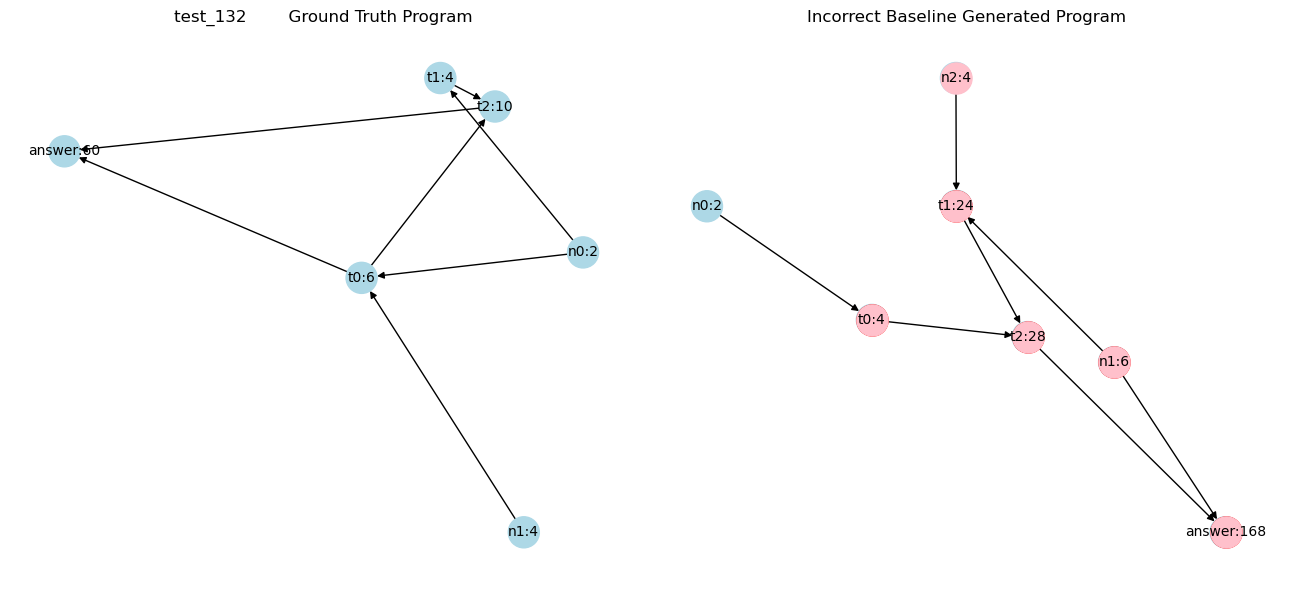

test_132
Unique nodes in Baseline Graph: {'t1', 'answer', 't2', 'n1', 't0'}
Unique nodes in S3C Graph: {'t1', 'n2', 't2', 'answer', 'n1', 't0'}
Unique edges in Baseline Graph: {('n0', 't1'), ('t0', 'answer'), ('n1', 't0')}
Unique edges in S3C Graph: {('n1', 'answer'), ('n1', 't1'), ('n2', 't1')}
GT Answer 60.0 , Basline Generated Answer: 168
----------------------------------------------------------------


In [90]:
print_single_graph_comparison('test_132', tf_intersection, baseline_dict, s3c_dict, incorrect_baseline_clusters, correct_s3c_clusters)

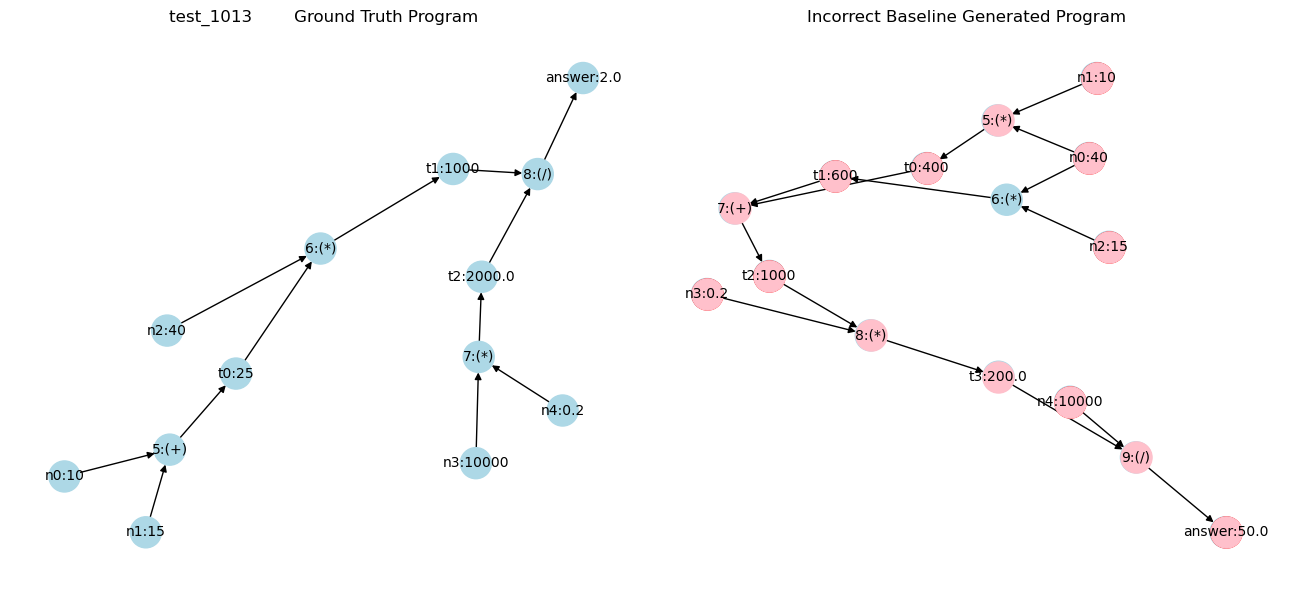

test_1013
Unique nodes in Baseline Graph: {'n0', 'n4', 't1', 'n3', 'n2', 't2', 'answer', '7:(*)', '5:(+)', 'n1', 't0', '8:(/)'}
Unique nodes in S3C Graph: {'n0', '7:(+)', 'n4', 't1', 'n3', 'n2', 't2', '5:(*)', '8:(*)', 'answer', 'n1', '9:(/)', 't0', 't3'}
Unique edges in Baseline Graph: {('n0', '5:(+)'), ('n3', '7:(*)'), ('n4', '7:(*)'), ('7:(*)', 't2'), ('n1', '5:(+)'), ('5:(+)', 't0'), ('8:(/)', 'answer'), ('t2', '8:(/)'), ('t0', '6:(*)'), ('t1', '8:(/)')}
Unique edges in S3C Graph: {('8:(*)', 't3'), ('t0', '7:(+)'), ('n0', '6:(*)'), ('n3', '8:(*)'), ('t3', '9:(/)'), ('9:(/)', 'answer'), ('n4', '9:(/)'), ('t1', '7:(+)'), ('n0', '5:(*)'), ('t2', '8:(*)'), ('7:(+)', 't2'), ('n1', '5:(*)'), ('5:(*)', 't0')}
GT Answer 2.0 , S3C Generated Answer: 50.0
----------------------------------------------------------------


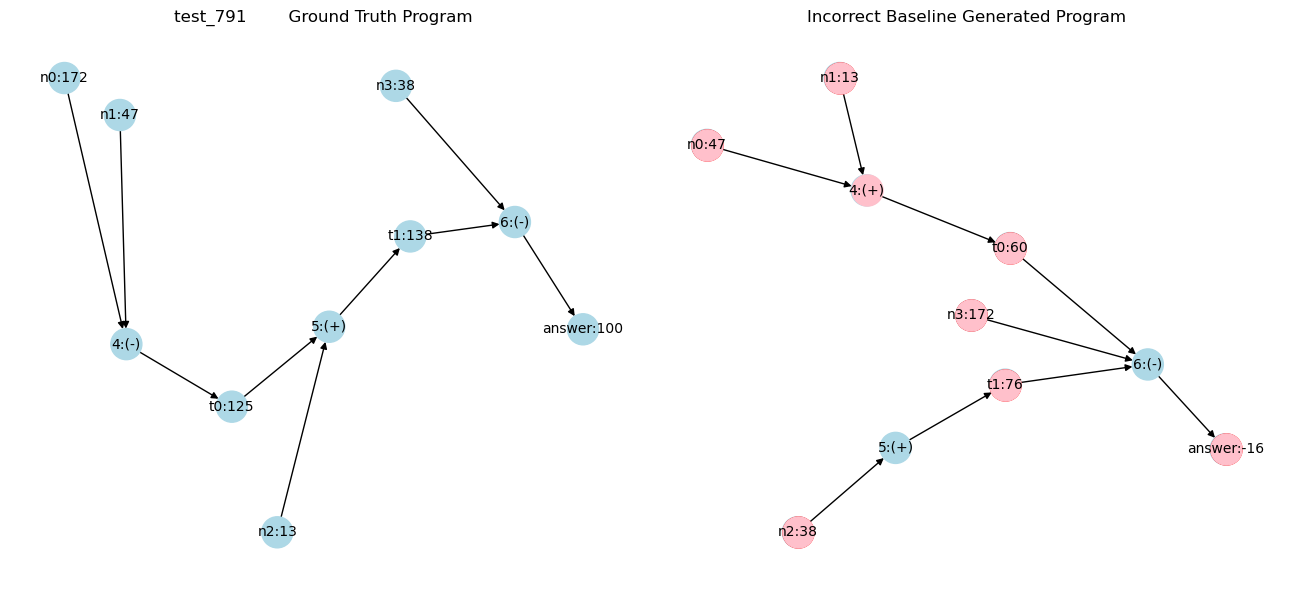

test_791
Unique nodes in Baseline Graph: {'n0', '4:(-)', 't1', 'n3', 'n2', 'answer', 'n1', 't0'}
Unique nodes in S3C Graph: {'n0', '4:(+)', 't1', 'n3', 'n2', 'answer', 'n1', 't0'}
Unique edges in Baseline Graph: {('n1', '4:(-)'), ('t0', '5:(+)'), ('n0', '4:(-)'), ('4:(-)', 't0')}
Unique edges in S3C Graph: {('n0', '4:(+)'), ('n1', '4:(+)'), ('4:(+)', 't0'), ('t0', '6:(-)')}
GT Answer 100.0 , S3C Generated Answer: 36
----------------------------------------------------------------


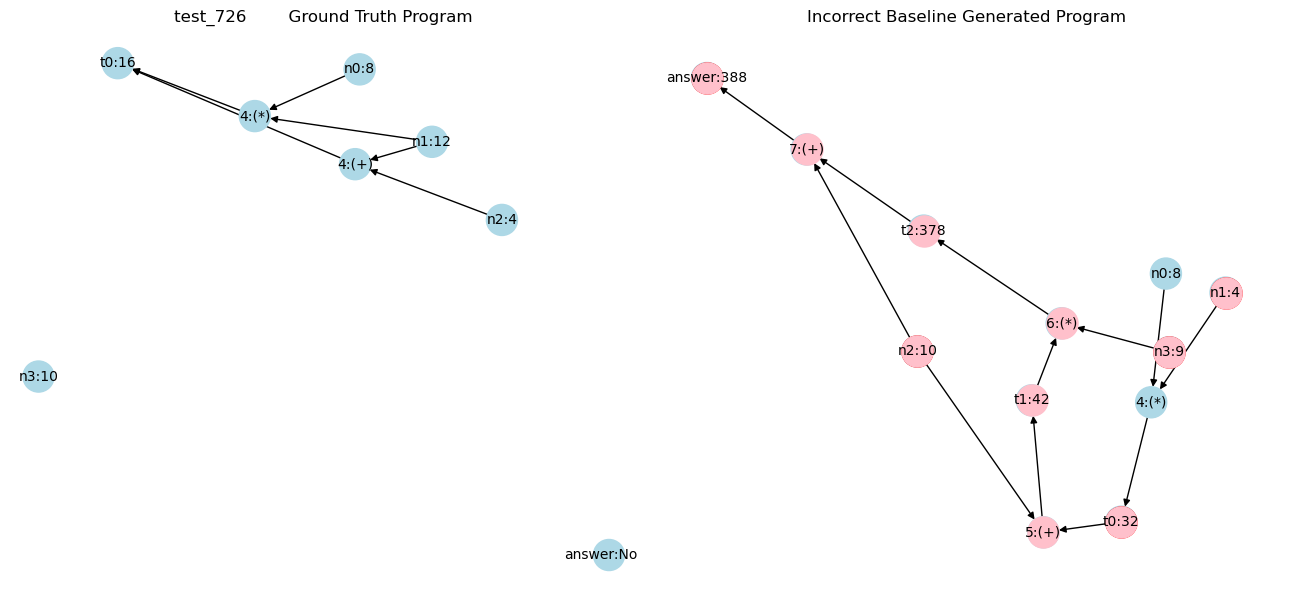

test_726
Unique nodes in Baseline Graph: {'4:(+)', 'n3', 'n2', 'answer', 'n1', 't0'}
Unique nodes in S3C Graph: {'7:(+)', 't1', 'n3', 'n2', 't2', 'answer', '5:(+)', 'n1', 't0', '6:(*)'}
Unique edges in Baseline Graph: {('n1', '4:(+)'), ('4:(+)', 't0'), ('n2', '4:(+)')}
Unique edges in S3C Graph: {('t2', '7:(+)'), ('t1', '6:(*)'), ('7:(+)', 'answer'), ('n2', '5:(+)'), ('n3', '6:(*)'), ('5:(+)', 't1'), ('t0', '5:(+)'), ('n2', '7:(+)'), ('6:(*)', 't2')}
GT Answer 10.0 , S3C Generated Answer: 388
----------------------------------------------------------------


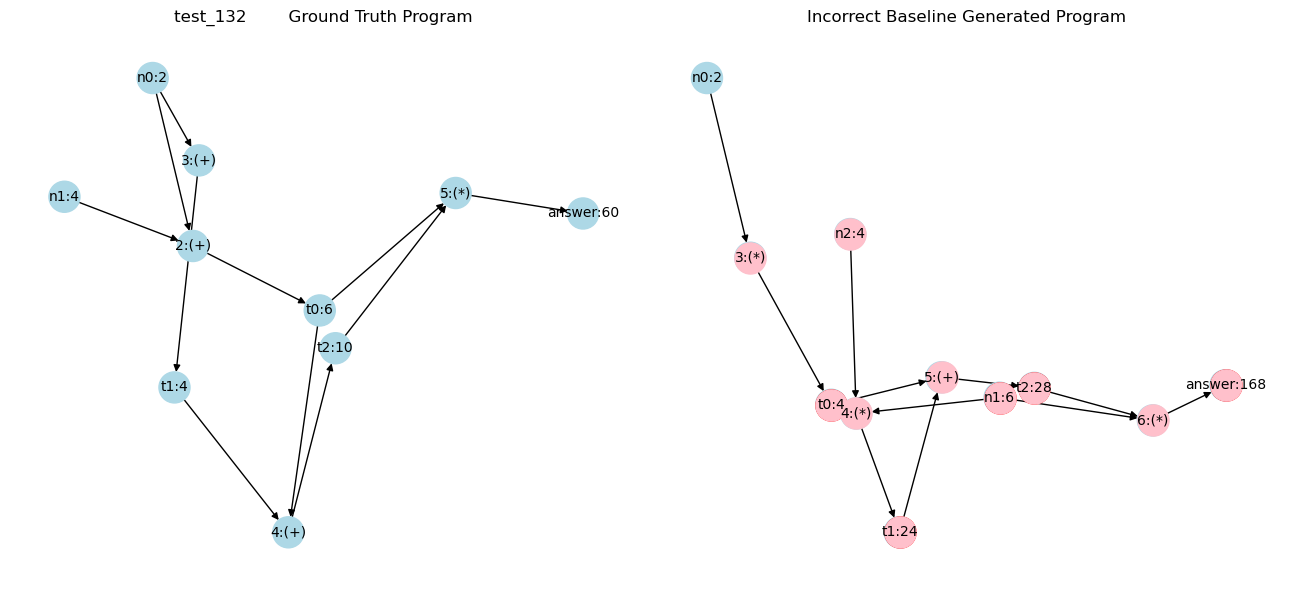

test_132
Unique nodes in Baseline Graph: {'4:(+)', 't1', 'answer', 't2', '5:(*)', 'n1', 't0', '3:(+)', '2:(+)'}
Unique nodes in S3C Graph: {'t1', 'n2', 't2', 'answer', '5:(+)', '3:(*)', 'n1', 't0', '6:(*)', '4:(*)'}
Unique edges in Baseline Graph: {('2:(+)', 't0'), ('t2', '5:(*)'), ('t0', '4:(+)'), ('n0', '2:(+)'), ('3:(+)', 't1'), ('5:(*)', 'answer'), ('4:(+)', 't2'), ('t1', '4:(+)'), ('n1', '2:(+)'), ('n0', '3:(+)'), ('t0', '5:(*)')}
Unique edges in S3C Graph: {('n1', '4:(*)'), ('n0', '3:(*)'), ('6:(*)', 'answer'), ('3:(*)', 't0'), ('4:(*)', 't1'), ('n1', '6:(*)'), ('t0', '5:(+)'), ('t2', '6:(*)'), ('5:(+)', 't2'), ('t1', '5:(+)'), ('n2', '4:(*)')}
GT Answer 60.0 , S3C Generated Answer: 168
----------------------------------------------------------------


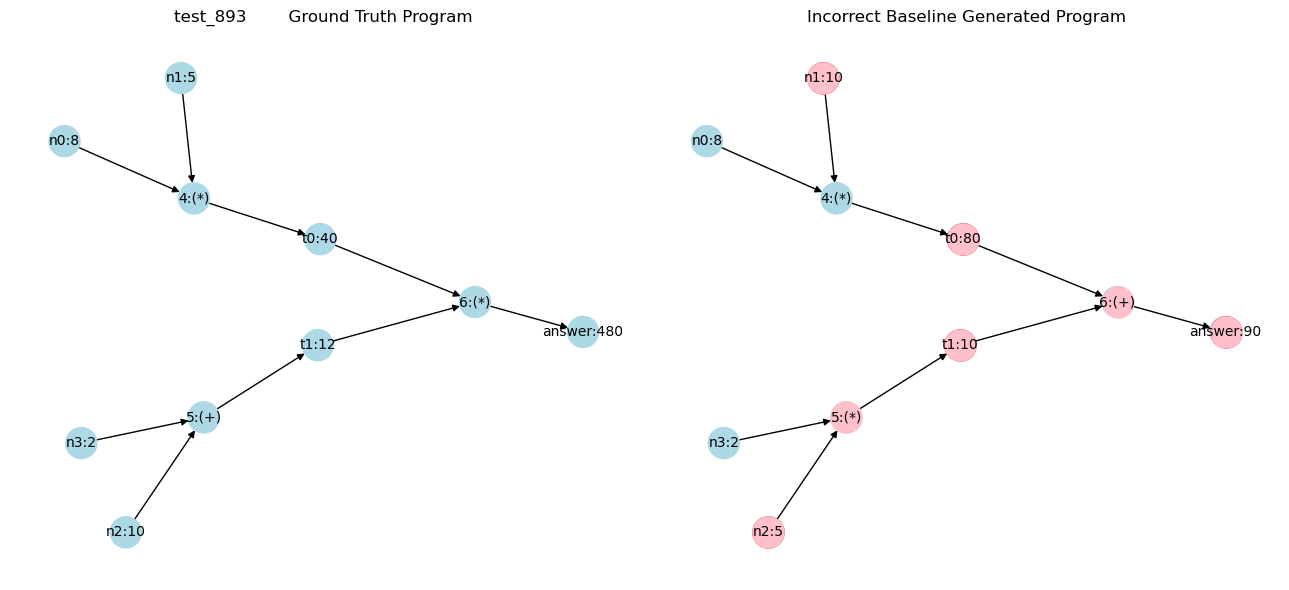

test_893
Unique nodes in Baseline Graph: {'t1', 'n2', 'answer', '5:(+)', 'n1', 't0', '6:(*)'}
Unique nodes in S3C Graph: {'t1', '6:(+)', 'n2', 'answer', '5:(*)', 'n1', 't0'}
Unique edges in Baseline Graph: {('t1', '6:(*)'), ('n2', '5:(+)'), ('n3', '5:(+)'), ('6:(*)', 'answer'), ('5:(+)', 't1'), ('t0', '6:(*)')}
Unique edges in S3C Graph: {('6:(+)', 'answer'), ('t0', '6:(+)'), ('5:(*)', 't1'), ('n2', '5:(*)'), ('n3', '5:(*)'), ('t1', '6:(+)')}
GT Answer 480.0 , S3C Generated Answer: 90
----------------------------------------------------------------


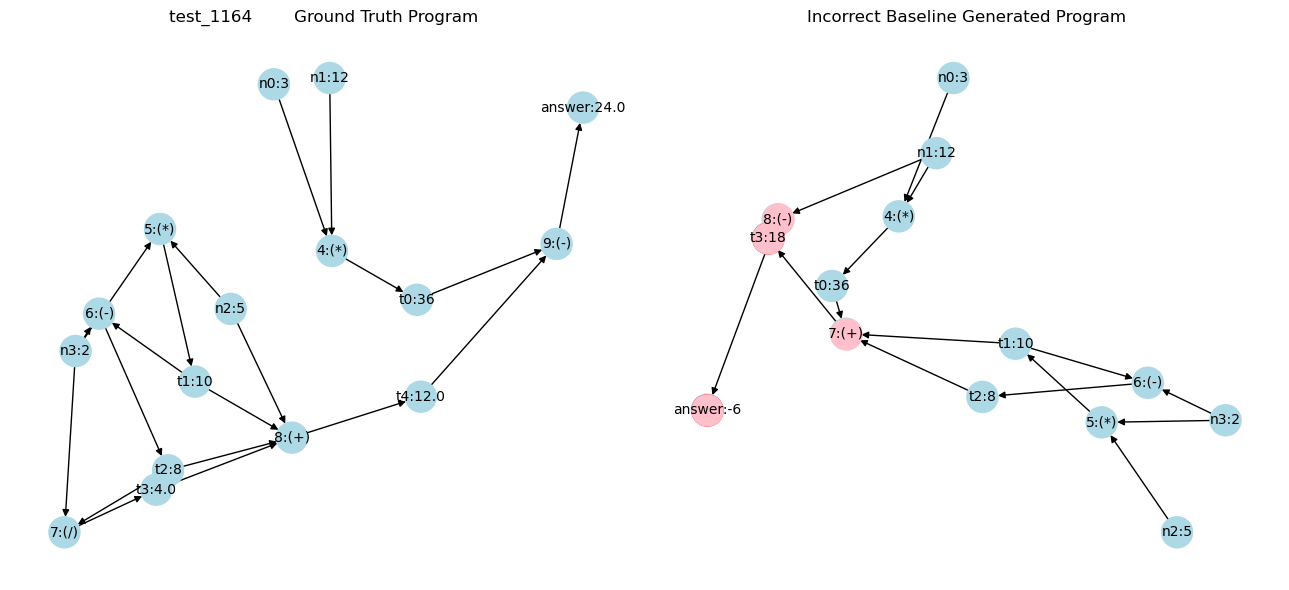

test_1164
Unique nodes in Baseline Graph: {'answer', 't4', '9:(-)', '7:(/)', '8:(+)', 't3'}
Unique nodes in S3C Graph: {'7:(+)', '8:(-)', 't3', 'answer'}
Unique edges in Baseline Graph: {('t2', '8:(+)'), ('t3', '8:(+)'), ('t4', '9:(-)'), ('n3', '7:(/)'), ('t1', '8:(+)'), ('7:(/)', 't3'), ('t2', '7:(/)'), ('n2', '8:(+)'), ('9:(-)', 'answer'), ('t0', '9:(-)'), ('8:(+)', 't4')}
Unique edges in S3C Graph: {('t2', '7:(+)'), ('t3', '8:(-)'), ('8:(-)', 'answer'), ('t1', '7:(+)'), ('7:(+)', 't3'), ('n1', '8:(-)'), ('t0', '7:(+)')}
GT Answer 9.0 , S3C Generated Answer: -42
----------------------------------------------------------------


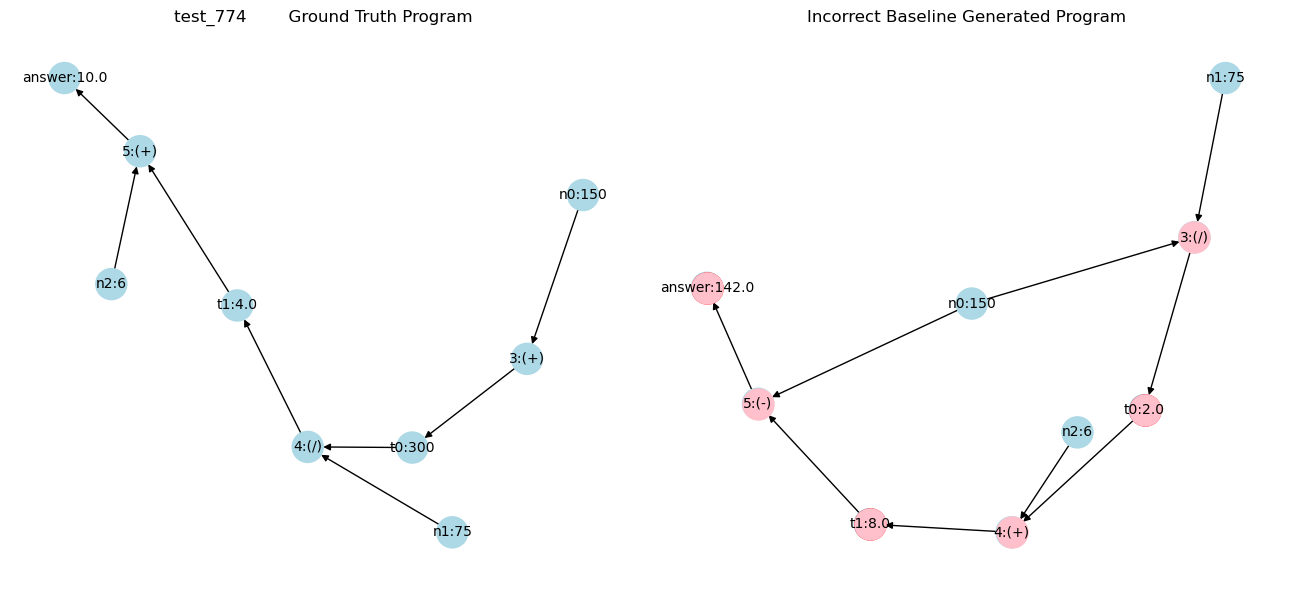

test_774
Unique nodes in Baseline Graph: {'t1', '4:(/)', 'answer', '5:(+)', 't0', '3:(+)'}
Unique nodes in S3C Graph: {'4:(+)', 't1', 'answer', '3:(/)', 't0', '5:(-)'}
Unique edges in Baseline Graph: {('5:(+)', 'answer'), ('n2', '5:(+)'), ('3:(+)', 't0'), ('4:(/)', 't1'), ('n1', '4:(/)'), ('n0', '3:(+)'), ('t0', '4:(/)'), ('t1', '5:(+)')}
Unique edges in S3C Graph: {('5:(-)', 'answer'), ('4:(+)', 't1'), ('t0', '4:(+)'), ('3:(/)', 't0'), ('n0', '3:(/)'), ('t1', '5:(-)'), ('n0', '5:(-)'), ('n1', '3:(/)'), ('n2', '4:(+)')}
GT Answer 10.0 , S3C Generated Answer: 142.0
----------------------------------------------------------------


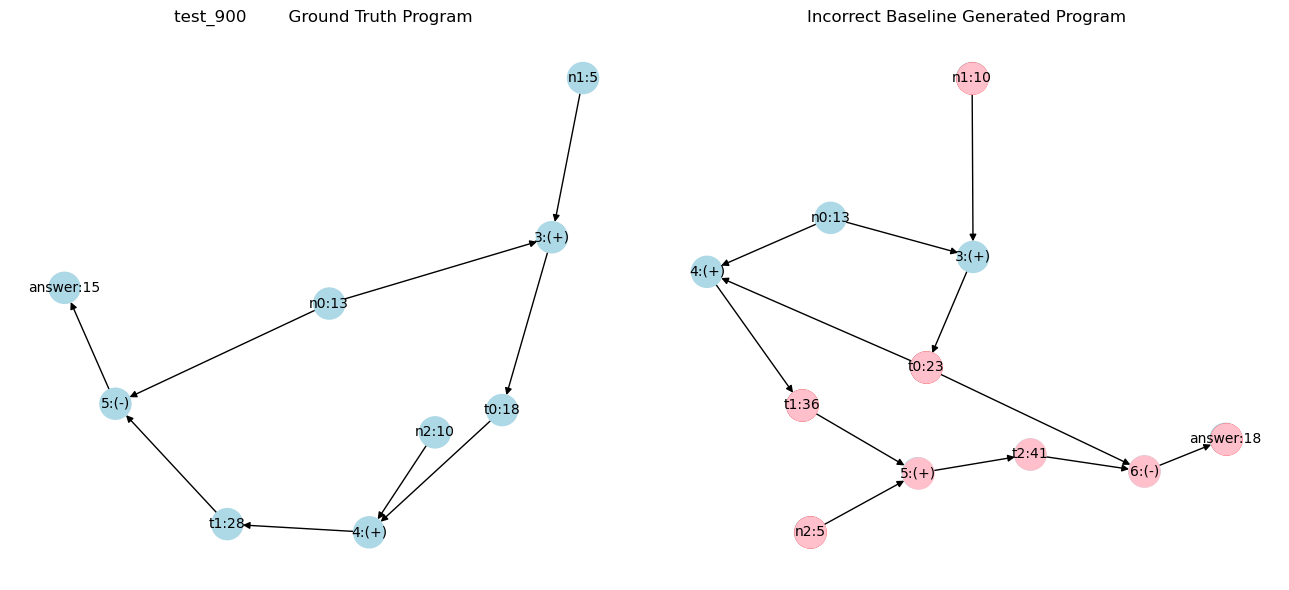

test_900
Unique nodes in Baseline Graph: {'t1', 'n2', 'answer', 'n1', 't0', '5:(-)'}
Unique nodes in S3C Graph: {'6:(-)', 't1', 'n2', 't2', 'answer', '5:(+)', 'n1', 't0'}
Unique edges in Baseline Graph: {('n0', '5:(-)'), ('5:(-)', 'answer'), ('t1', '5:(-)'), ('n2', '4:(+)')}
Unique edges in S3C Graph: {('n2', '5:(+)'), ('t0', '6:(-)'), ('n0', '4:(+)'), ('6:(-)', 'answer'), ('t2', '6:(-)'), ('5:(+)', 't2'), ('t1', '5:(+)')}
GT Answer 15.0 , S3C Generated Answer: 18
----------------------------------------------------------------


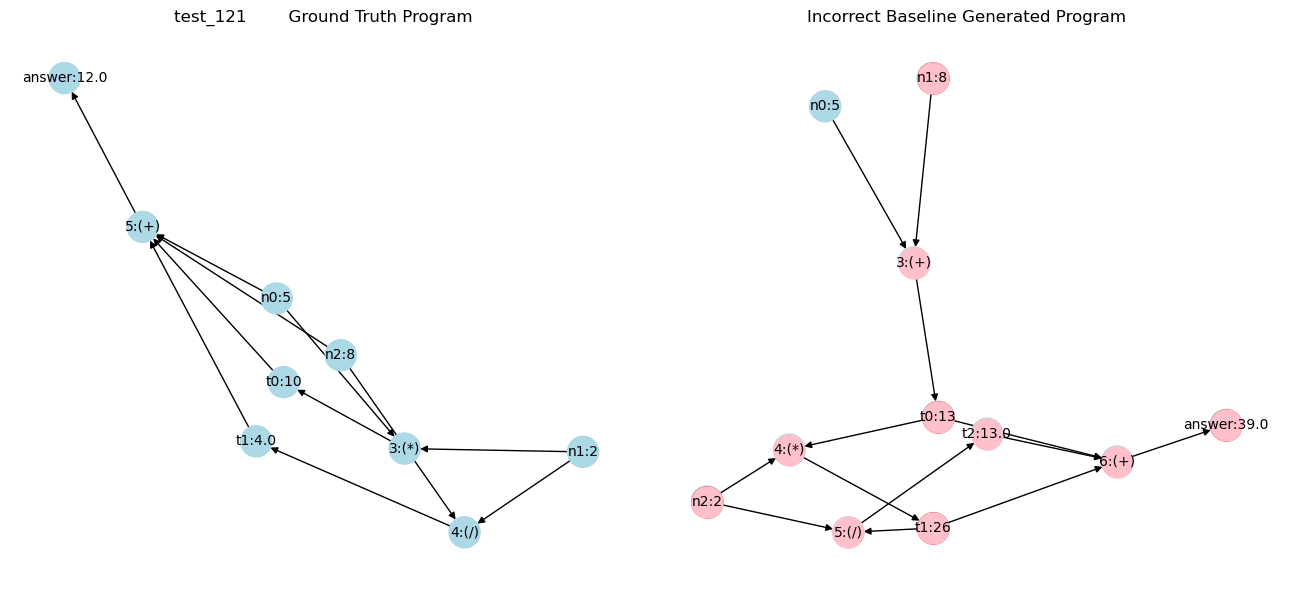

test_121
Unique nodes in Baseline Graph: {'t1', '4:(/)', 'n2', 'answer', '5:(+)', '3:(*)', 'n1', 't0'}
Unique nodes in S3C Graph: {'5:(/)', 't1', '6:(+)', 'n2', 't2', 'answer', 'n1', 't0', '3:(+)', '4:(*)'}
Unique edges in Baseline Graph: {('n0', '5:(+)'), ('5:(+)', 'answer'), ('n2', '5:(+)'), ('n0', '3:(*)'), ('3:(*)', 't0'), ('n2', '4:(/)'), ('n1', '3:(*)'), ('t0', '5:(+)'), ('n1', '4:(/)'), ('4:(/)', 't1'), ('t1', '5:(+)')}
Unique edges in S3C Graph: {('t1', '6:(+)'), ('n1', '3:(+)'), ('t1', '5:(/)'), ('6:(+)', 'answer'), ('3:(+)', 't0'), ('t0', '4:(*)'), ('5:(/)', 't2'), ('4:(*)', 't1'), ('t0', '6:(+)'), ('n2', '5:(/)'), ('n0', '3:(+)'), ('t2', '6:(+)'), ('n2', '4:(*)')}
GT Answer 27.0 , S3C Generated Answer: 52.0
----------------------------------------------------------------


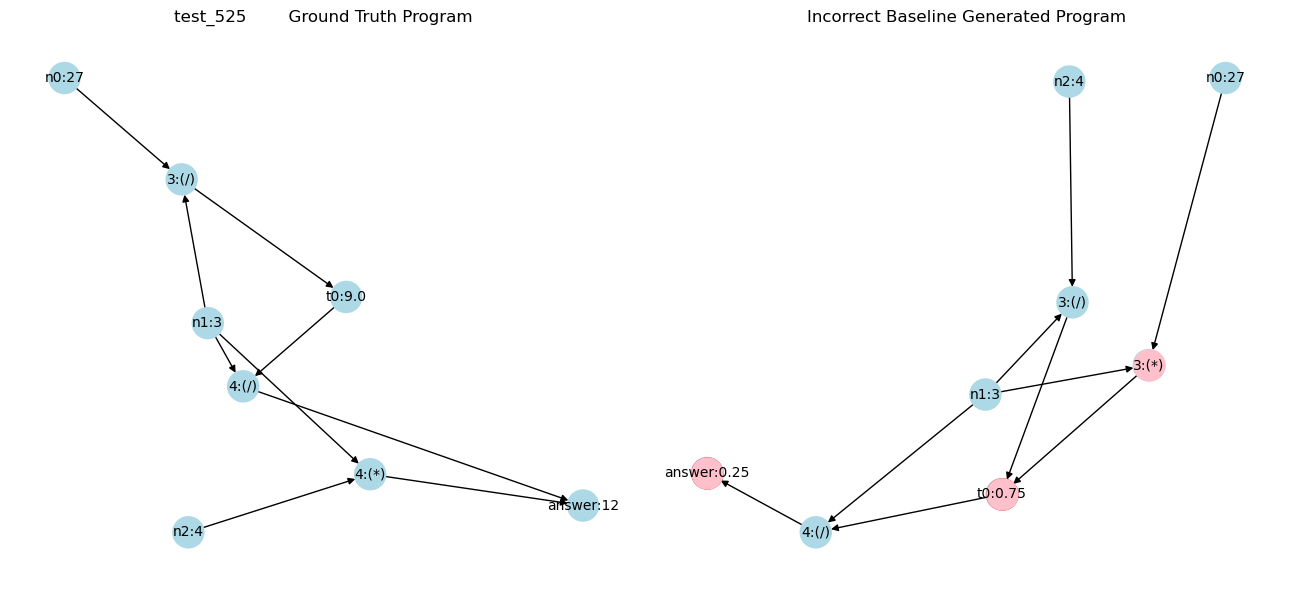

test_525
Unique nodes in Baseline Graph: {'t0', '4:(*)', 'answer'}
Unique nodes in S3C Graph: {'t0', '3:(*)', 'answer'}
Unique edges in Baseline Graph: {('n2', '4:(*)'), ('n1', '4:(*)'), ('4:(*)', 'answer'), ('n0', '3:(/)')}
Unique edges in S3C Graph: {('n0', '3:(*)'), ('3:(*)', 't0'), ('n1', '3:(*)'), ('n2', '3:(/)')}
GT Answer 12.0 , S3C Generated Answer: 6.75
----------------------------------------------------------------


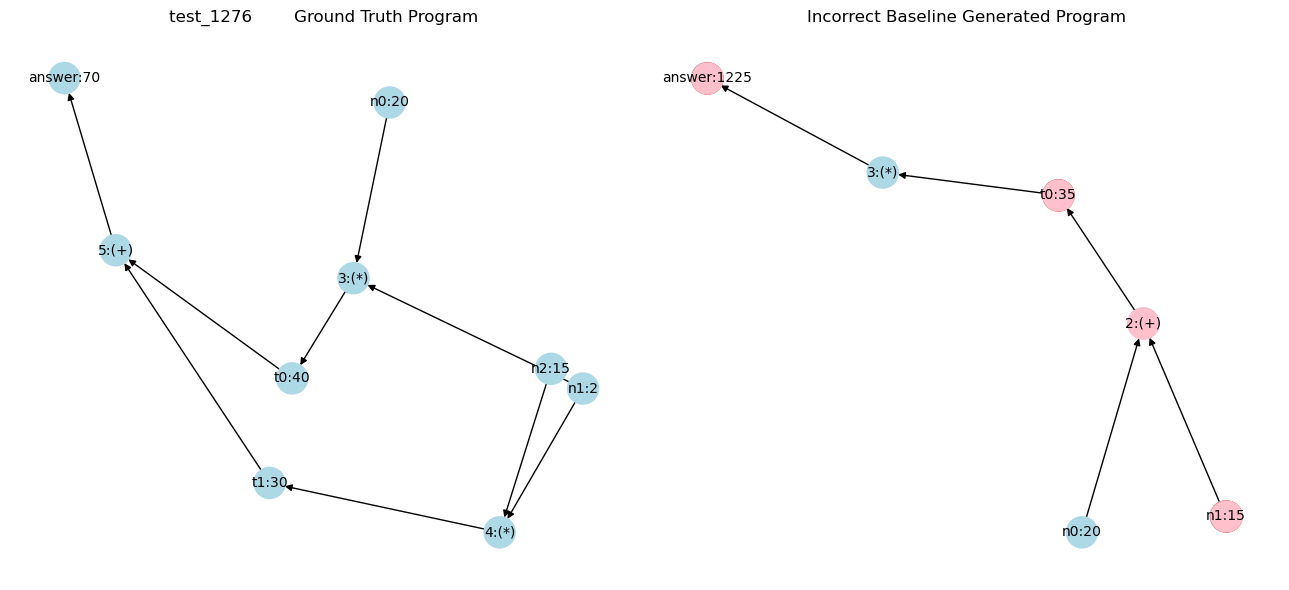

test_1276
Unique nodes in Baseline Graph: {'t1', 'n2', 'answer', '5:(+)', 'n1', 't0', '4:(*)'}
Unique nodes in S3C Graph: {'t0', 'answer', 'n1', '2:(+)'}
Unique edges in Baseline Graph: {('n1', '4:(*)'), ('5:(+)', 'answer'), ('n0', '3:(*)'), ('3:(*)', 't0'), ('4:(*)', 't1'), ('n1', '3:(*)'), ('t0', '5:(+)'), ('t1', '5:(+)'), ('n2', '4:(*)')}
Unique edges in S3C Graph: {('2:(+)', 't0'), ('n0', '2:(+)'), ('n1', '2:(+)'), ('3:(*)', 'answer'), ('t0', '3:(*)')}
GT Answer 70.0 , S3C Generated Answer: 1225
----------------------------------------------------------------


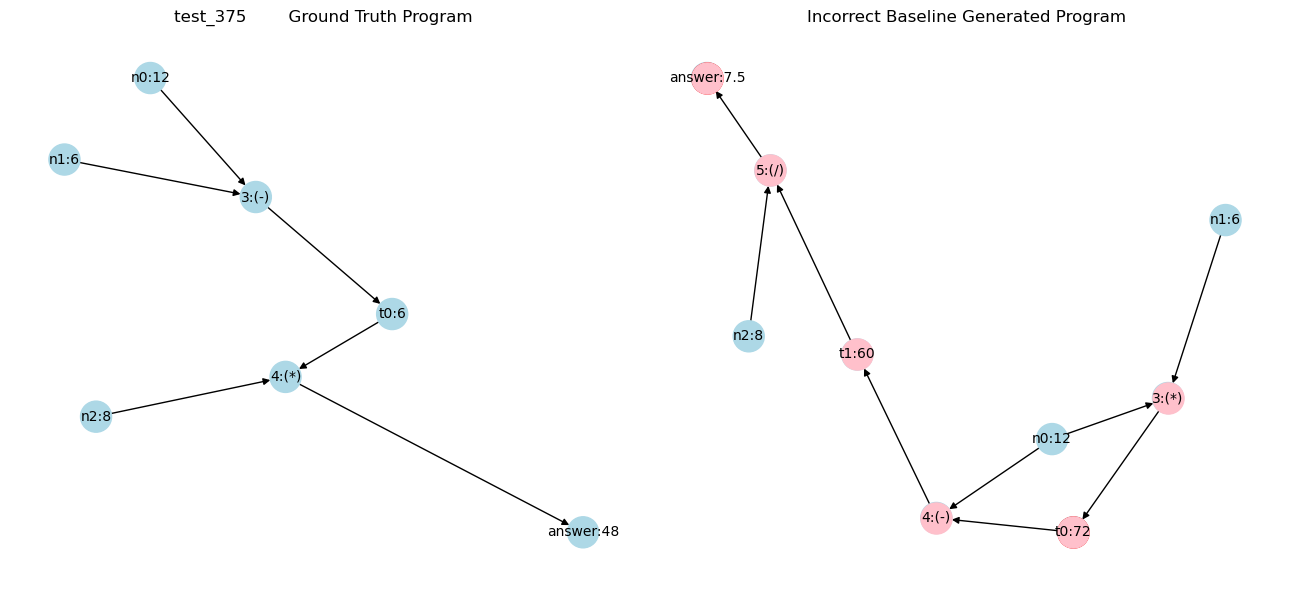

test_375
Unique nodes in Baseline Graph: {'3:(-)', 't0', '4:(*)', 'answer'}
Unique nodes in S3C Graph: {'4:(-)', '5:(/)', 't1', 'answer', '3:(*)', 't0'}
Unique edges in Baseline Graph: {('t0', '4:(*)'), ('n0', '3:(-)'), ('3:(-)', 't0'), ('n1', '3:(-)'), ('4:(*)', 'answer'), ('n2', '4:(*)')}
Unique edges in S3C Graph: {('t0', '4:(-)'), ('5:(/)', 'answer'), ('n0', '3:(*)'), ('t1', '5:(/)'), ('3:(*)', 't0'), ('n0', '4:(-)'), ('n1', '3:(*)'), ('4:(-)', 't1'), ('n2', '5:(/)')}
GT Answer 48.0 , S3C Generated Answer: 7.5
----------------------------------------------------------------


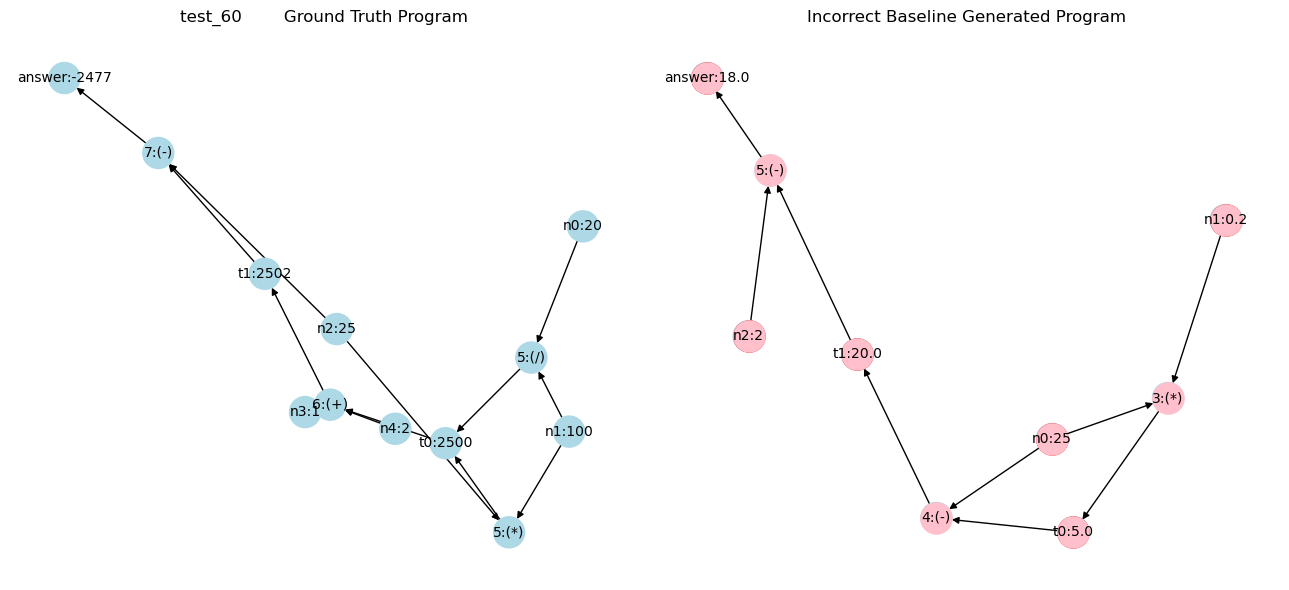

test_60
Unique nodes in Baseline Graph: {'n0', 'n4', '7:(-)', '5:(/)', '6:(+)', 'n3', 'n2', 't1', '5:(*)', 'answer', 'n1', 't0'}
Unique nodes in S3C Graph: {'n0', '4:(-)', 't1', 'n2', 'answer', '3:(*)', 'n1', 't0', '5:(-)'}
Unique edges in Baseline Graph: {('n0', '5:(/)'), ('5:(/)', 't0'), ('7:(-)', 'answer'), ('n4', '6:(+)'), ('n3', '6:(+)'), ('5:(*)', 't0'), ('t0', '6:(+)'), ('n1', '5:(/)'), ('6:(+)', 't1'), ('n2', '5:(*)'), ('t1', '7:(-)'), ('n1', '5:(*)'), ('n2', '7:(-)')}
Unique edges in S3C Graph: {('t0', '4:(-)'), ('5:(-)', 'answer'), ('n0', '3:(*)'), ('3:(*)', 't0'), ('n0', '4:(-)'), ('n1', '3:(*)'), ('4:(-)', 't1'), ('t1', '5:(-)'), ('n2', '5:(-)')}
GT Answer 17.0 , S3C Generated Answer: 18.0
----------------------------------------------------------------


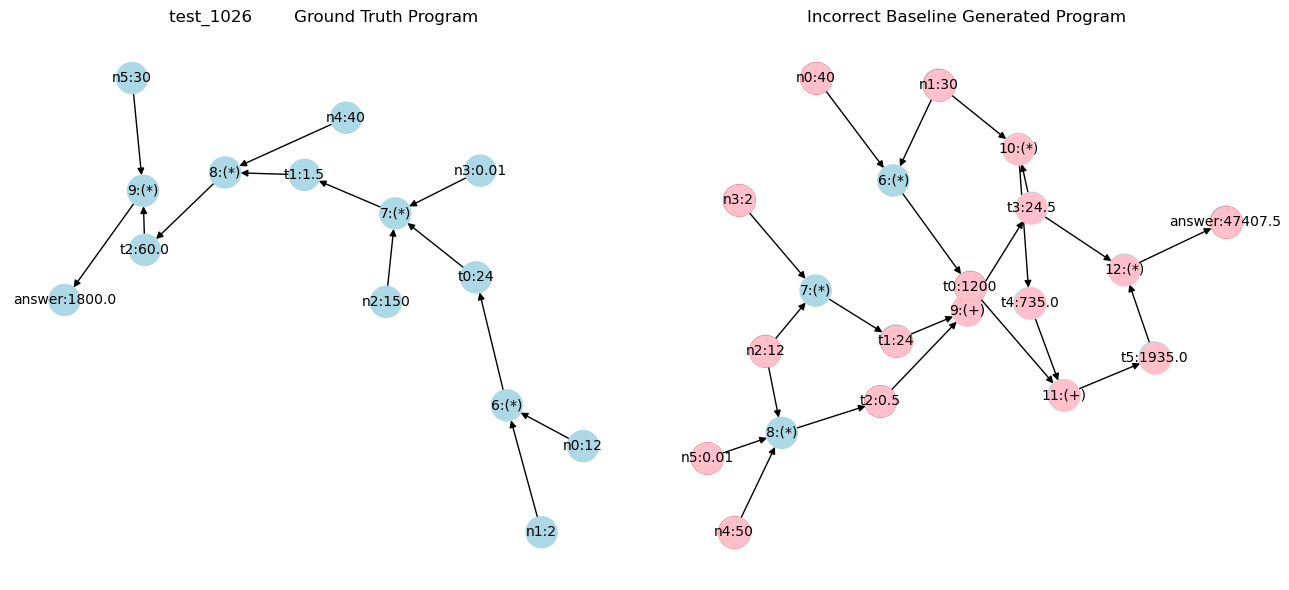

test_1026
Unique nodes in Baseline Graph: {'n0', '9:(*)', 'n4', 't1', 'n3', 'n2', 't2', 'answer', 'n1', 'n5', 't0'}
Unique nodes in S3C Graph: {'n0', 't5', '10:(*)', '12:(*)', 'n4', '9:(+)', 't1', 'n3', 'n2', 't2', 't4', 'answer', 'n1', 'n5', '11:(+)', 't0', 't3'}
Unique edges in Baseline Graph: {('t2', '9:(*)'), ('t0', '7:(*)'), ('9:(*)', 'answer'), ('n5', '9:(*)'), ('t1', '8:(*)')}
Unique edges in S3C Graph: {('t5', '12:(*)'), ('n2', '8:(*)'), ('t0', '11:(+)'), ('11:(+)', 't5'), ('n5', '8:(*)'), ('9:(+)', 't3'), ('t4', '11:(+)'), ('n1', '10:(*)'), ('t3', '12:(*)'), ('t2', '9:(+)'), ('t3', '10:(*)'), ('12:(*)', 'answer'), ('t1', '9:(+)'), ('10:(*)', 't4')}
GT Answer 43200.0 , S3C Generated Answer: 63000.0
----------------------------------------------------------------


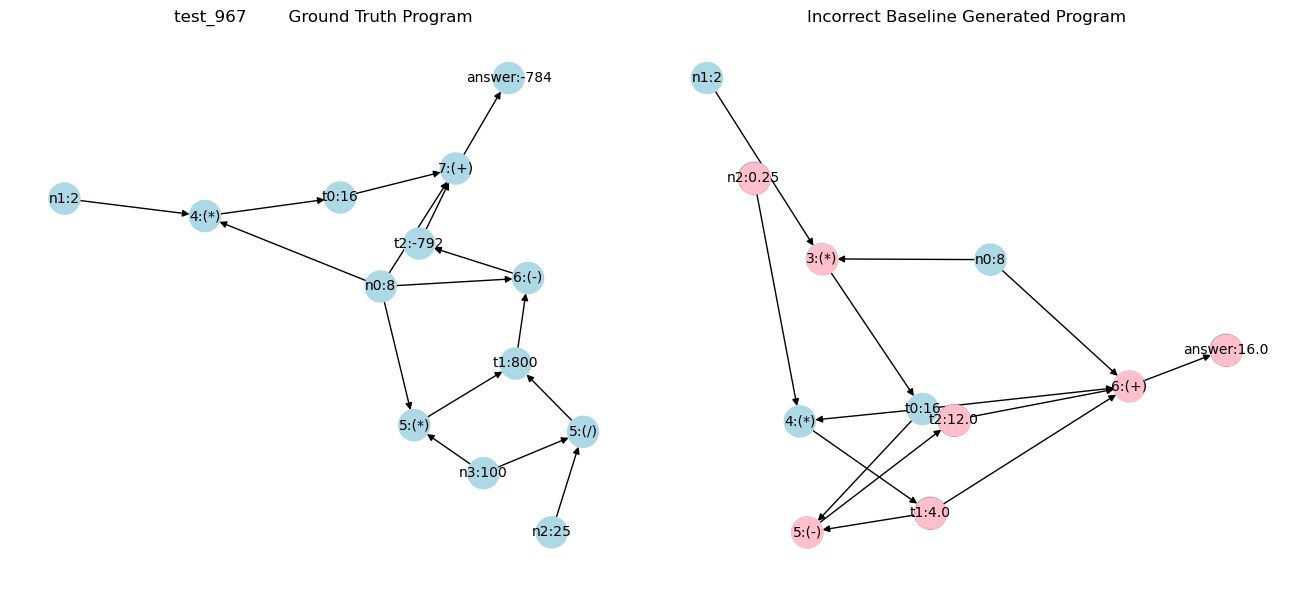

test_967
Unique nodes in Baseline Graph: {'7:(+)', '6:(-)', '5:(/)', 't1', 'n3', 'n2', 't2', '5:(*)', 'answer'}
Unique nodes in S3C Graph: {'t1', '6:(+)', 'n2', 't2', 'answer', '3:(*)', '5:(-)'}
Unique edges in Baseline Graph: {('t1', '6:(-)'), ('5:(/)', 't1'), ('n0', '6:(-)'), ('n1', '4:(*)'), ('t2', '7:(+)'), ('7:(+)', 'answer'), ('n3', '5:(*)'), ('6:(-)', 't2'), ('n0', '7:(+)'), ('n0', '5:(*)'), ('4:(*)', 't0'), ('5:(*)', 't1'), ('n2', '5:(/)'), ('n0', '4:(*)'), ('n3', '5:(/)'), ('t0', '7:(+)')}
Unique edges in S3C Graph: {('n0', '6:(+)'), ('t1', '6:(+)'), ('5:(-)', 't2'), ('n0', '3:(*)'), ('3:(*)', 't0'), ('t0', '4:(*)'), ('t0', '5:(-)'), ('6:(+)', 'answer'), ('4:(*)', 't1'), ('n1', '3:(*)'), ('t0', '6:(+)'), ('t1', '5:(-)'), ('t2', '6:(+)'), ('n2', '4:(*)')}
GT Answer 30.0 , S3C Generated Answer: 40.0
----------------------------------------------------------------


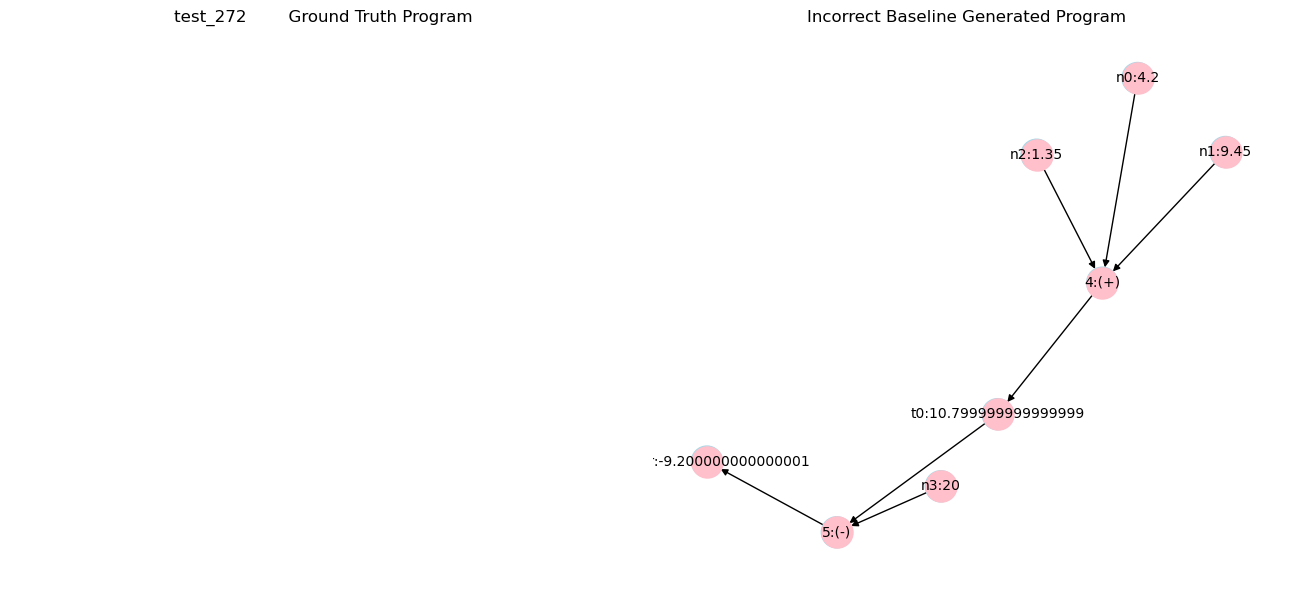

test_272
Unique nodes in Baseline Graph: set()
Unique nodes in S3C Graph: {'n0', '4:(+)', 'n3', 'n2', 'answer', 'n1', 't0', '5:(-)'}
Unique edges in Baseline Graph: set()
Unique edges in S3C Graph: {('5:(-)', 'answer'), ('4:(+)', 't0'), ('n3', '5:(-)'), ('t0', '5:(-)'), ('n0', '4:(+)'), ('n1', '4:(+)'), ('n2', '4:(+)')}
GT Answer 5.0 , S3C Generated Answer: -5.000000000000002
----------------------------------------------------------------


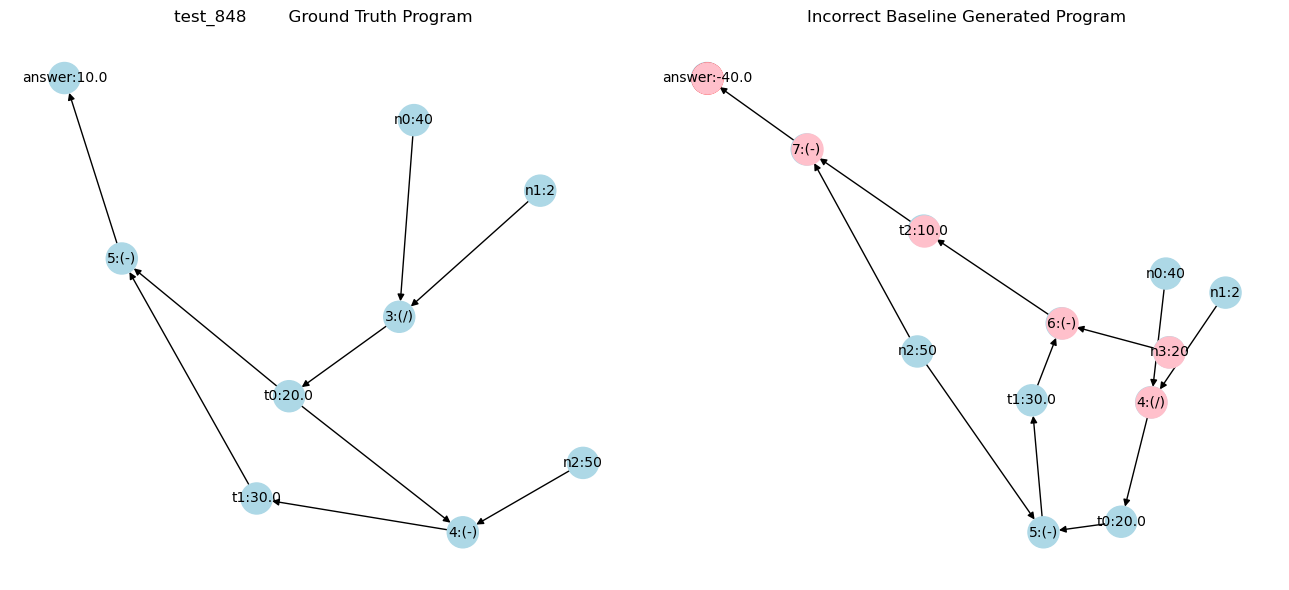

test_848
Unique nodes in Baseline Graph: {'4:(-)', 'answer', '3:(/)'}
Unique nodes in S3C Graph: {'6:(-)', '7:(-)', 'n3', '4:(/)', 't2', 'answer'}
Unique edges in Baseline Graph: {('t0', '4:(-)'), ('5:(-)', 'answer'), ('n2', '4:(-)'), ('3:(/)', 't0'), ('n0', '3:(/)'), ('4:(-)', 't1'), ('t1', '5:(-)'), ('n1', '3:(/)')}
Unique edges in S3C Graph: {('t1', '6:(-)'), ('6:(-)', 't2'), ('n0', '4:(/)'), ('t2', '7:(-)'), ('n3', '6:(-)'), ('5:(-)', 't1'), ('7:(-)', 'answer'), ('n1', '4:(/)'), ('4:(/)', 't0'), ('n2', '7:(-)'), ('n2', '5:(-)')}
GT Answer 10.0 , S3C Generated Answer: -40.0
----------------------------------------------------------------


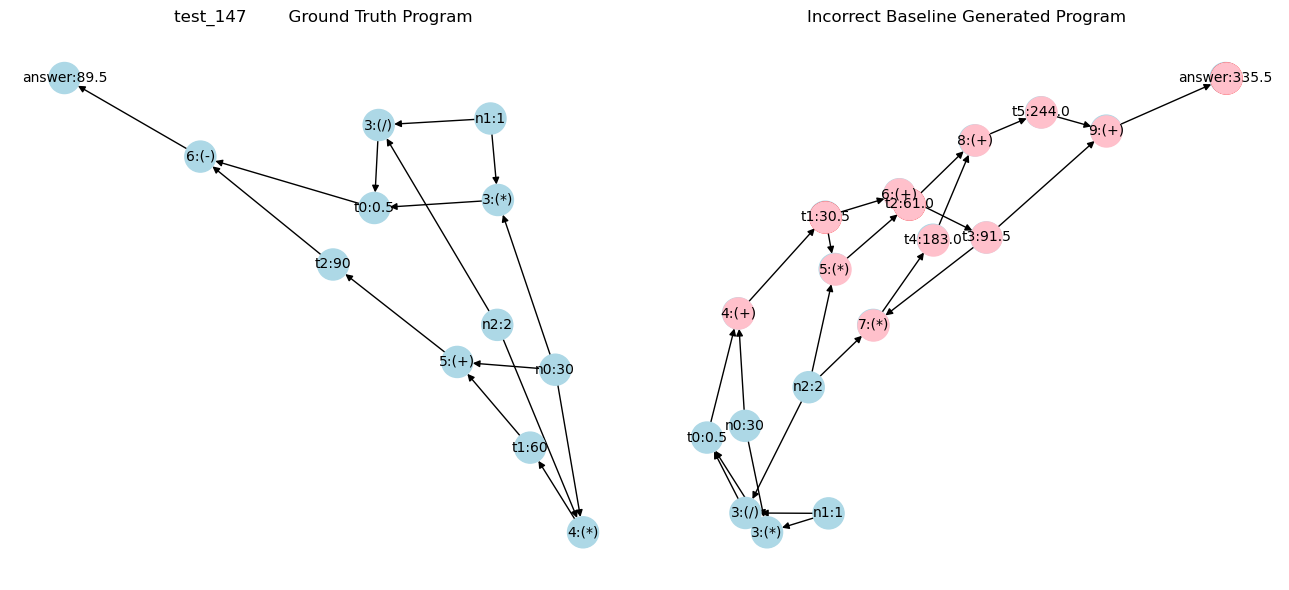

test_147
Unique nodes in Baseline Graph: {'6:(-)', 't1', 'answer', 't2', '5:(+)', '4:(*)'}
Unique nodes in S3C Graph: {'t5', '4:(+)', '9:(+)', '6:(+)', 't1', 'answer', 't2', '5:(*)', 't4', '7:(*)', '8:(+)', 't3'}
Unique edges in Baseline Graph: {('n0', '5:(+)'), ('4:(*)', 't1'), ('t0', '6:(-)'), ('6:(-)', 'answer'), ('t2', '6:(-)'), ('n0', '4:(*)'), ('5:(+)', 't2'), ('t1', '5:(+)'), ('n2', '4:(*)')}
Unique edges in S3C Graph: {('5:(*)', 't2'), ('4:(+)', 't1'), ('t0', '4:(+)'), ('t3', '7:(*)'), ('t2', '8:(+)'), ('8:(+)', 't5'), ('t5', '9:(+)'), ('t1', '5:(*)'), ('n0', '4:(+)'), ('t3', '9:(+)'), ('7:(*)', 't4'), ('6:(+)', 't3'), ('t4', '8:(+)'), ('n2', '5:(*)'), ('9:(+)', 'answer'), ('t2', '6:(+)'), ('n2', '7:(*)'), ('t1', '6:(+)')}
GT Answer 75.0 , S3C Generated Answer: 495.0
----------------------------------------------------------------


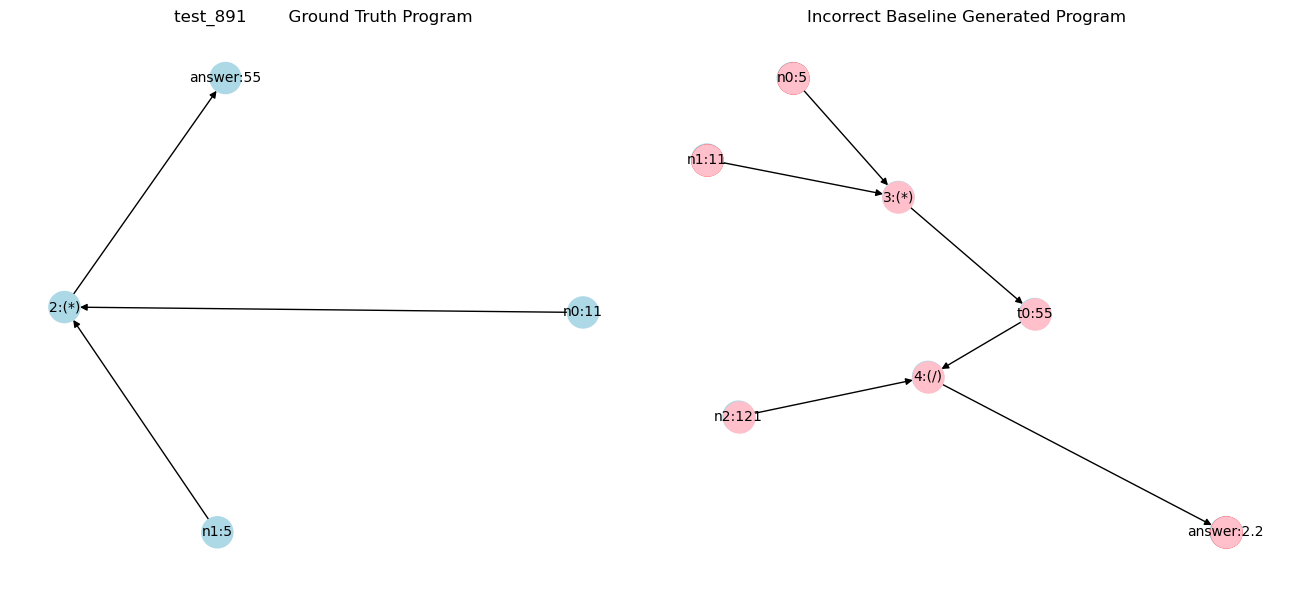

test_891
Unique nodes in Baseline Graph: {'n0', 'answer', 'n1', '2:(*)'}
Unique nodes in S3C Graph: {'n0', 'n2', '4:(/)', 'answer', '3:(*)', 'n1', 't0'}
Unique edges in Baseline Graph: {('n0', '2:(*)'), ('2:(*)', 'answer'), ('n1', '2:(*)')}
Unique edges in S3C Graph: {('n0', '3:(*)'), ('4:(/)', 'answer'), ('3:(*)', 't0'), ('n2', '4:(/)'), ('n1', '3:(*)'), ('t0', '4:(/)')}
GT Answer 55.0 , S3C Generated Answer: 2.2
----------------------------------------------------------------


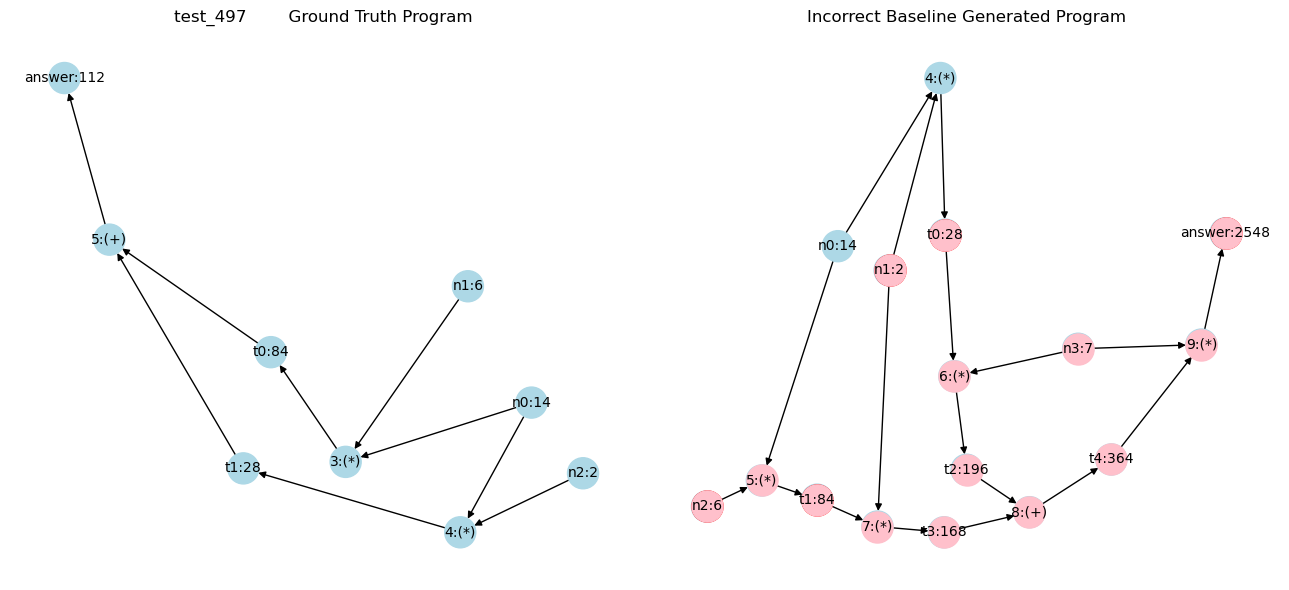

test_497
Unique nodes in Baseline Graph: {'t1', 'n2', 'answer', '5:(+)', '3:(*)', 'n1', 't0'}
Unique nodes in S3C Graph: {'9:(*)', 't1', 'n3', 'n2', 't2', '5:(*)', 't4', 'answer', '7:(*)', 'n1', 't0', '8:(+)', '6:(*)', 't3'}
Unique edges in Baseline Graph: {('5:(+)', 'answer'), ('n0', '3:(*)'), ('3:(*)', 't0'), ('4:(*)', 't1'), ('n1', '3:(*)'), ('t0', '5:(+)'), ('t1', '5:(+)'), ('n2', '4:(*)')}
Unique edges in S3C Graph: {('7:(*)', 't3'), ('n1', '4:(*)'), ('t2', '8:(+)'), ('t3', '8:(+)'), ('t4', '9:(*)'), ('9:(*)', 'answer'), ('n3', '6:(*)'), ('t1', '7:(*)'), ('n0', '5:(*)'), ('4:(*)', 't0'), ('8:(+)', 't4'), ('5:(*)', 't1'), ('n2', '5:(*)'), ('t0', '6:(*)'), ('n3', '9:(*)'), ('n1', '7:(*)'), ('6:(*)', 't2')}
GT Answer 112.0 , S3C Generated Answer: 2548
----------------------------------------------------------------


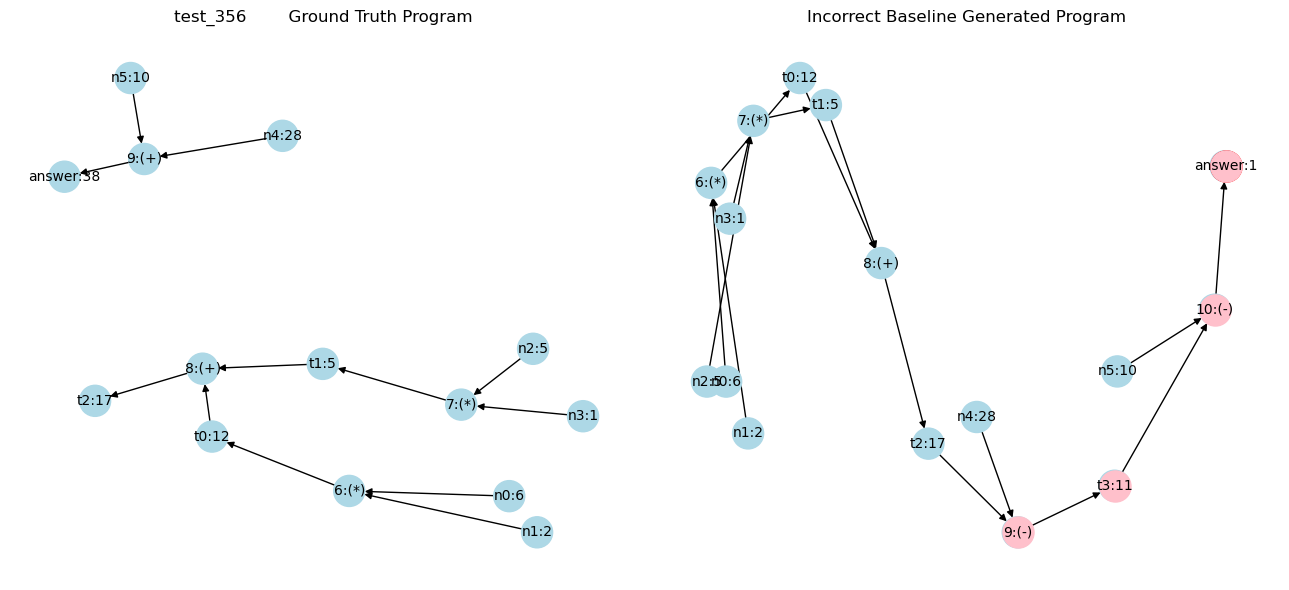

test_356
Unique nodes in Baseline Graph: {'9:(+)', 'answer'}
Unique nodes in S3C Graph: {'10:(-)', '9:(-)', 't3', 'answer'}
Unique edges in Baseline Graph: {('n5', '9:(+)'), ('9:(+)', 'answer'), ('n4', '9:(+)')}
Unique edges in S3C Graph: {('10:(-)', 'answer'), ('t2', '9:(-)'), ('9:(-)', 't3'), ('n5', '10:(-)'), ('t3', '10:(-)'), ('n4', '9:(-)')}
GT Answer 21.0 , S3C Generated Answer: 1
----------------------------------------------------------------


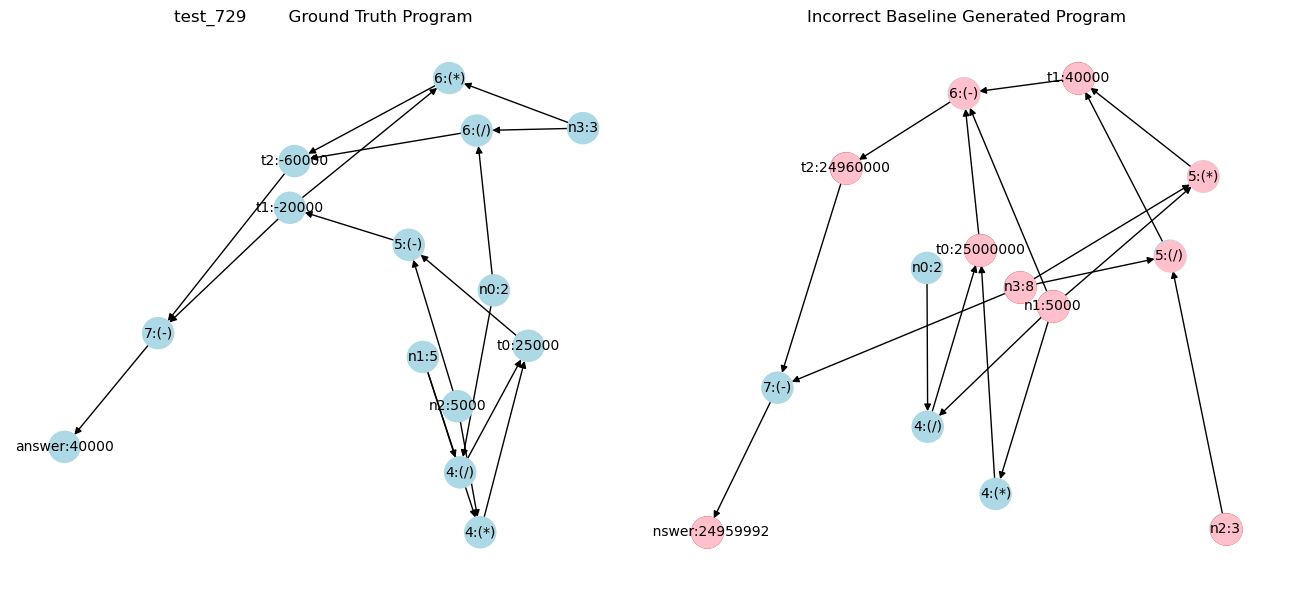

test_729
Unique nodes in Baseline Graph: {'t1', 'n3', 'n2', 't2', 'answer', '6:(/)', 'n1', 't0', '5:(-)', '6:(*)'}
Unique nodes in S3C Graph: {'6:(-)', '5:(/)', 't1', 'n3', 'n2', 't2', '5:(*)', 'answer', 'n1', 't0'}
Unique edges in Baseline Graph: {('6:(/)', 't2'), ('t1', '6:(*)'), ('n3', '6:(/)'), ('t0', '5:(-)'), ('5:(-)', 't1'), ('n3', '6:(*)'), ('6:(*)', 't2'), ('n0', '6:(/)'), ('t1', '7:(-)'), ('n2', '5:(-)'), ('n2', '4:(*)')}
Unique edges in S3C Graph: {('n3', '7:(-)'), ('5:(/)', 't1'), ('t1', '6:(-)'), ('n3', '5:(*)'), ('6:(-)', 't2'), ('n1', '6:(-)'), ('t0', '6:(-)'), ('5:(*)', 't1'), ('n2', '5:(/)'), ('n3', '5:(/)'), ('n1', '5:(*)')}
GT Answer 1000.0 , S3C Generated Answer: 3115.0
----------------------------------------------------------------


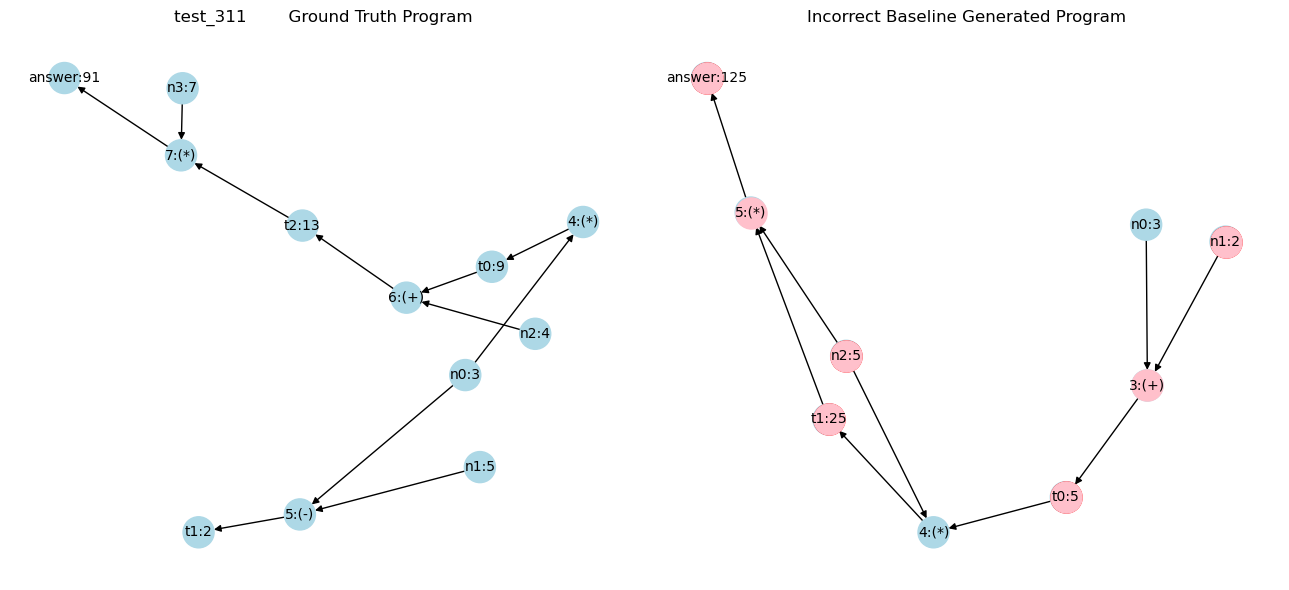

test_311
Unique nodes in Baseline Graph: {'t1', 'n3', 'n2', '6:(+)', 't2', 'answer', '7:(*)', 'n1', 't0', '5:(-)'}
Unique nodes in S3C Graph: {'t1', 'n2', 'answer', '5:(*)', 'n1', 't0', '3:(+)'}
Unique edges in Baseline Graph: {('n3', '7:(*)'), ('6:(+)', 't2'), ('n1', '5:(-)'), ('t2', '7:(*)'), ('5:(-)', 't1'), ('n2', '6:(+)'), ('4:(*)', 't0'), ('7:(*)', 'answer'), ('t0', '6:(+)'), ('n0', '5:(-)'), ('n0', '4:(*)')}
Unique edges in S3C Graph: {('n1', '3:(+)'), ('5:(*)', 'answer'), ('3:(+)', 't0'), ('t0', '4:(*)'), ('4:(*)', 't1'), ('t1', '5:(*)'), ('n2', '5:(*)'), ('n0', '3:(+)'), ('n2', '4:(*)')}
GT Answer 91.0 , S3C Generated Answer: 125
----------------------------------------------------------------


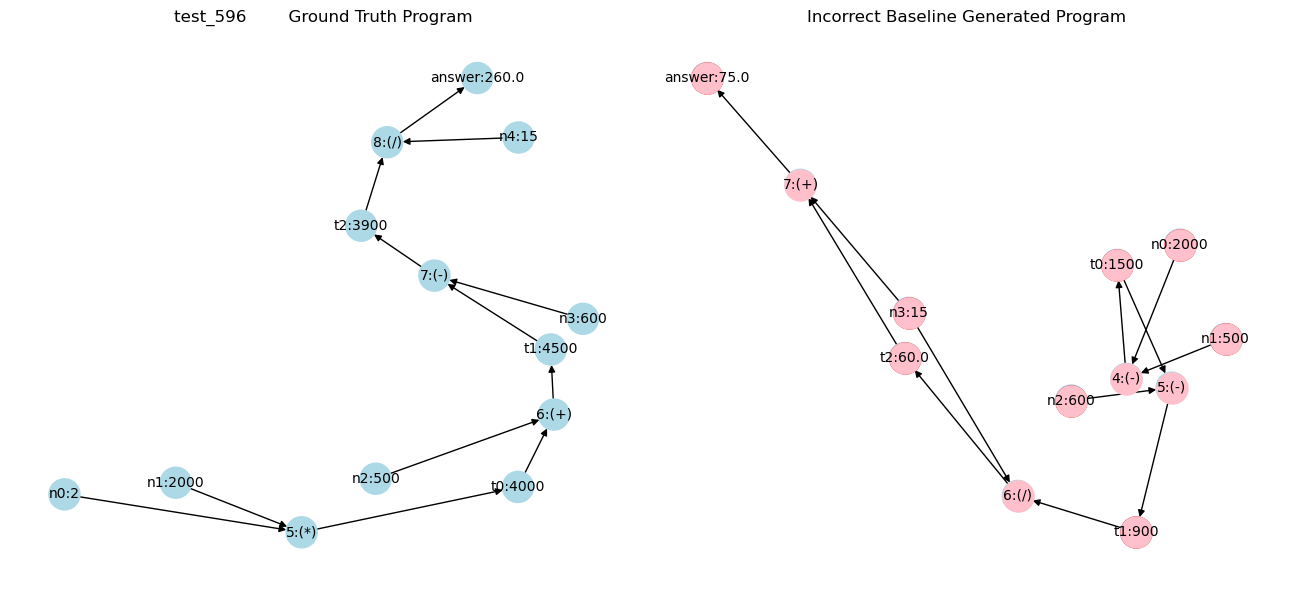

test_596
Unique nodes in Baseline Graph: {'n0', 'n4', '7:(-)', '6:(+)', 'n3', 'n2', 't1', '5:(*)', 't2', 'answer', 'n1', 't0', '8:(/)'}
Unique nodes in S3C Graph: {'n0', '4:(-)', '7:(+)', 't1', 'n3', 'n2', 't2', 'answer', '6:(/)', 'n1', 't0', '5:(-)'}
Unique edges in Baseline Graph: {('n3', '7:(-)'), ('7:(-)', 't2'), ('n4', '8:(/)'), ('n2', '6:(+)'), ('n0', '5:(*)'), ('t0', '6:(+)'), ('6:(+)', 't1'), ('t1', '7:(-)'), ('t2', '8:(/)'), ('8:(/)', 'answer'), ('n1', '5:(*)'), ('5:(*)', 't0')}
Unique edges in S3C Graph: {('6:(/)', 't2'), ('t2', '7:(+)'), ('7:(+)', 'answer'), ('n3', '6:(/)'), ('t0', '5:(-)'), ('n0', '4:(-)'), ('5:(-)', 't1'), ('t1', '6:(/)'), ('4:(-)', 't0'), ('n1', '4:(-)'), ('n3', '7:(+)'), ('n2', '5:(-)')}
GT Answer 260.0 , S3C Generated Answer: 75.0
----------------------------------------------------------------


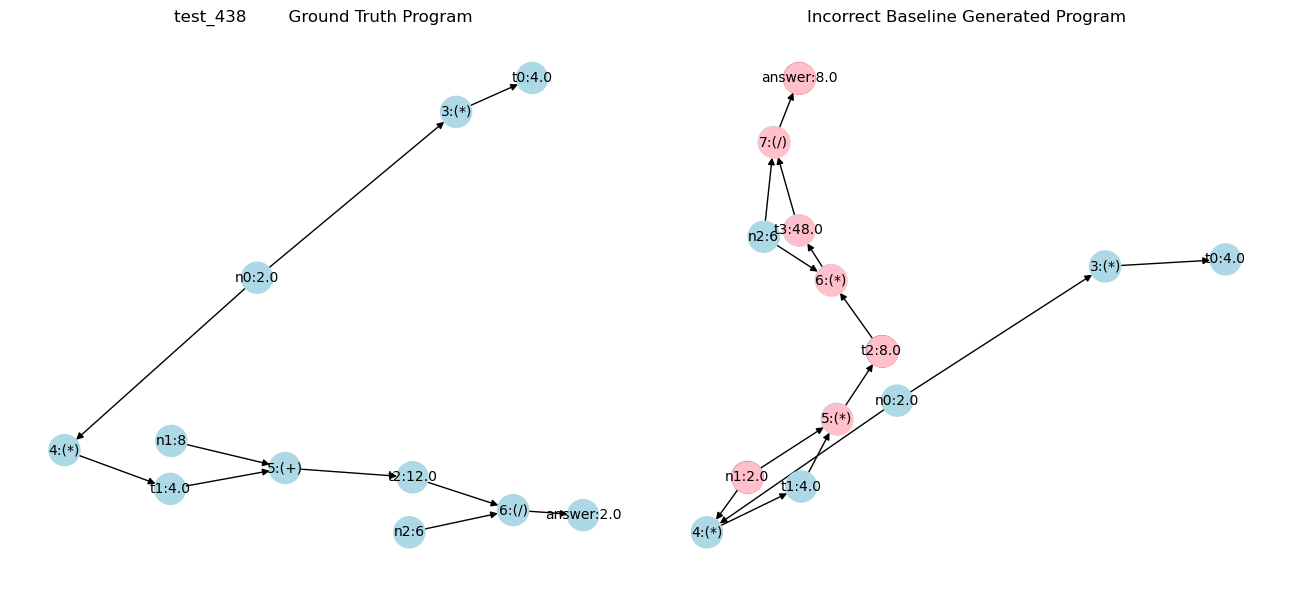

test_438
Unique nodes in Baseline Graph: {'answer', 't2', '6:(/)', '5:(+)', 'n1'}
Unique nodes in S3C Graph: {'answer', 't2', '5:(*)', 'n1', '7:(/)', '6:(*)', 't3'}
Unique edges in Baseline Graph: {('n2', '6:(/)'), ('n1', '5:(+)'), ('6:(/)', 'answer'), ('t2', '6:(/)'), ('5:(+)', 't2'), ('t1', '5:(+)')}
Unique edges in S3C Graph: {('5:(*)', 't2'), ('7:(/)', 'answer'), ('n1', '4:(*)'), ('n2', '7:(/)'), ('n2', '6:(*)'), ('t1', '5:(*)'), ('t3', '7:(/)'), ('t2', '6:(*)'), ('6:(*)', 't3'), ('n1', '5:(*)')}
GT Answer 2.0 , S3C Generated Answer: 8.0
----------------------------------------------------------------


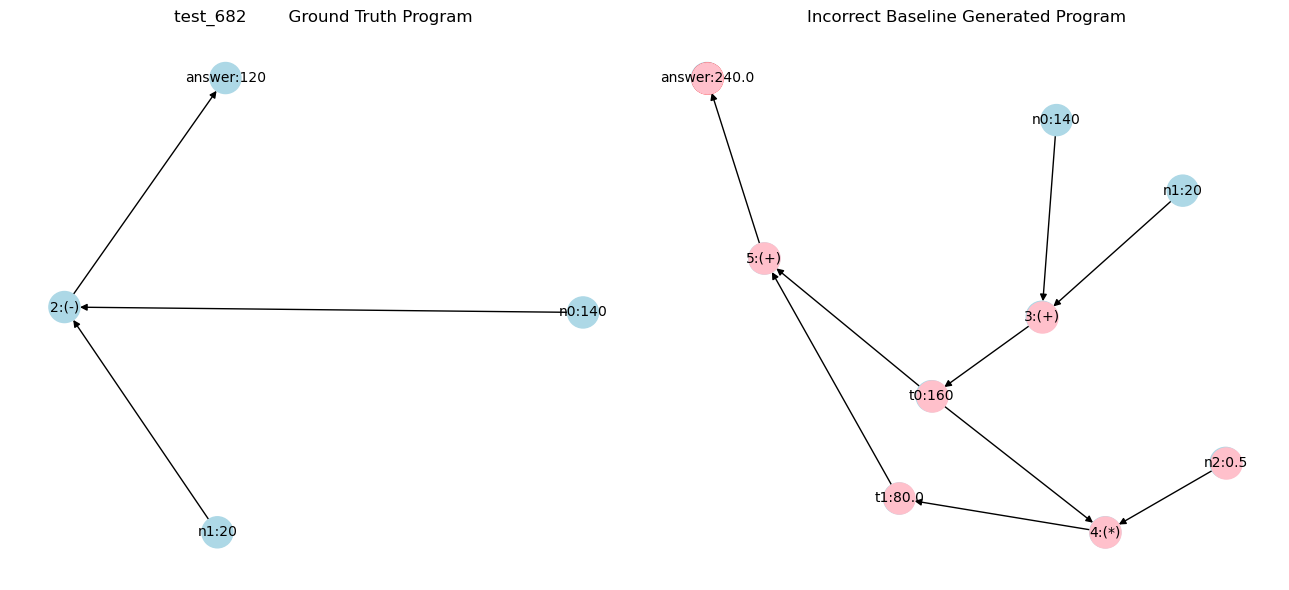

test_682
Unique nodes in Baseline Graph: {'2:(-)', 'answer'}
Unique nodes in S3C Graph: {'t1', 'n2', 'answer', '5:(+)', 't0', '3:(+)', '4:(*)'}
Unique edges in Baseline Graph: {('n0', '2:(-)'), ('n1', '2:(-)'), ('2:(-)', 'answer')}
Unique edges in S3C Graph: {('n1', '3:(+)'), ('5:(+)', 'answer'), ('t0', '4:(*)'), ('3:(+)', 't0'), ('4:(*)', 't1'), ('t0', '5:(+)'), ('n0', '3:(+)'), ('t1', '5:(+)'), ('n2', '4:(*)')}
GT Answer 80.0 , S3C Generated Answer: 240.0
----------------------------------------------------------------


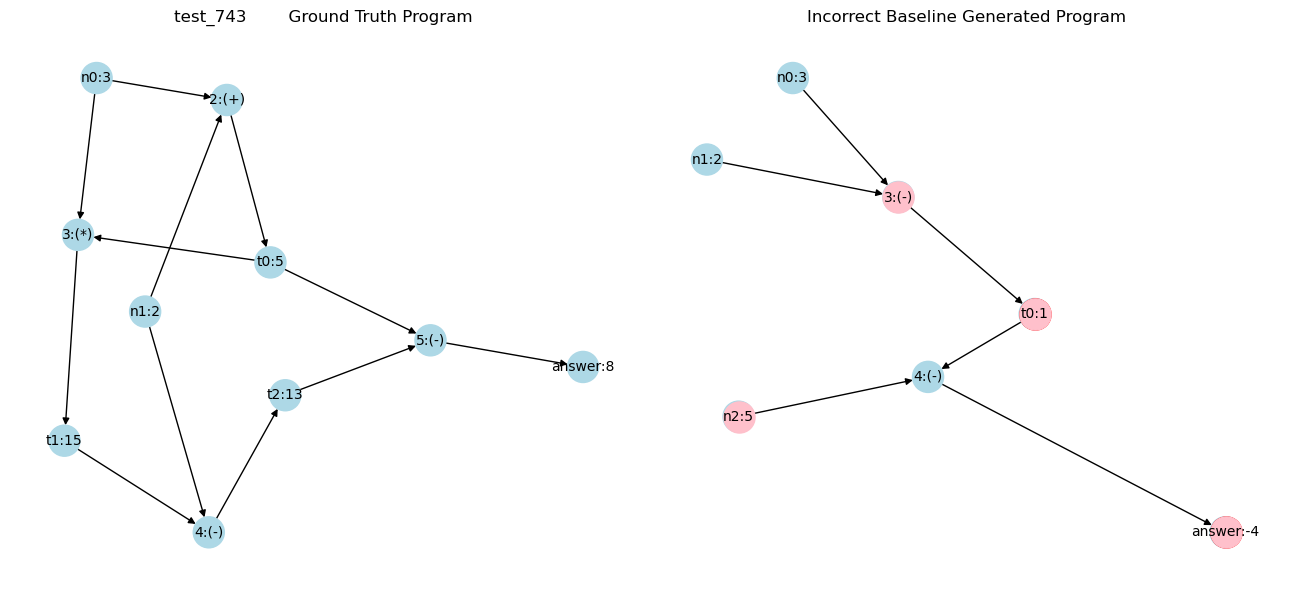

test_743
Unique nodes in Baseline Graph: {'t1', 'answer', 't2', '3:(*)', 't0', '5:(-)', '2:(+)'}
Unique nodes in S3C Graph: {'3:(-)', 't0', 'answer', 'n2'}
Unique edges in Baseline Graph: {('3:(*)', 't1'), ('2:(+)', 't0'), ('5:(-)', 'answer'), ('n0', '2:(+)'), ('n0', '3:(*)'), ('t0', '5:(-)'), ('t1', '4:(-)'), ('t2', '5:(-)'), ('n1', '2:(+)'), ('n1', '4:(-)'), ('t0', '3:(*)'), ('4:(-)', 't2')}
Unique edges in S3C Graph: {('t0', '4:(-)'), ('4:(-)', 'answer'), ('n0', '3:(-)'), ('3:(-)', 't0'), ('n1', '3:(-)'), ('n2', '4:(-)')}
GT Answer 8.0 , S3C Generated Answer: -4
----------------------------------------------------------------


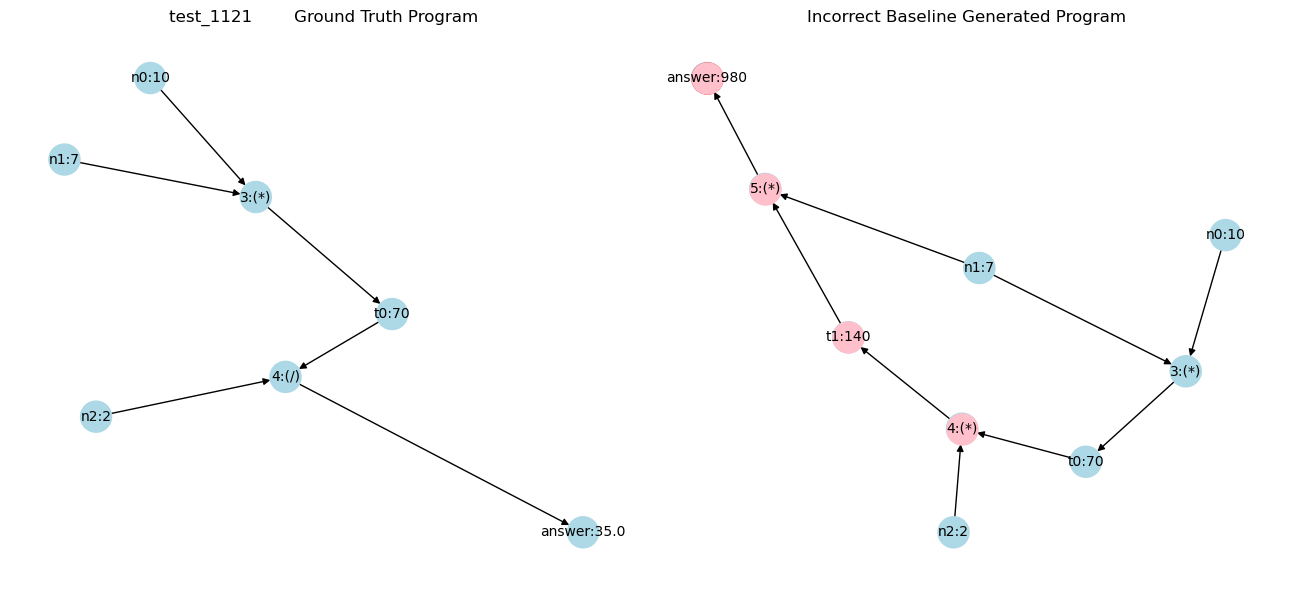

test_1121
Unique nodes in Baseline Graph: {'answer', '4:(/)'}
Unique nodes in S3C Graph: {'5:(*)', 't1', '4:(*)', 'answer'}
Unique edges in Baseline Graph: {('n2', '4:(/)'), ('4:(/)', 'answer'), ('t0', '4:(/)')}
Unique edges in S3C Graph: {('5:(*)', 'answer'), ('t0', '4:(*)'), ('t1', '5:(*)'), ('4:(*)', 't1'), ('n1', '5:(*)'), ('n2', '4:(*)')}
GT Answer 35.0 , S3C Generated Answer: 980
----------------------------------------------------------------


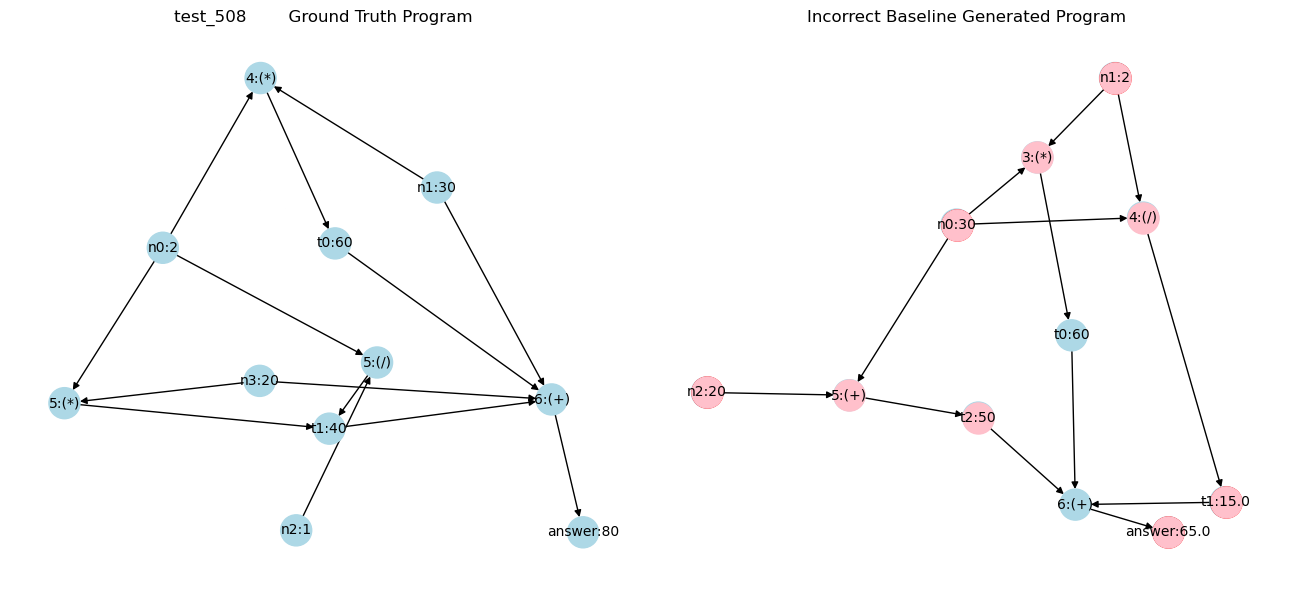

test_508
Unique nodes in Baseline Graph: {'n0', '5:(/)', 't1', 'n3', 'n2', 'answer', '5:(*)', 'n1', '4:(*)'}
Unique nodes in S3C Graph: {'n0', 't1', '4:(/)', 'n2', 't2', 'answer', '5:(+)', '3:(*)', 'n1'}
Unique edges in Baseline Graph: {('5:(/)', 't1'), ('n1', '4:(*)'), ('n0', '5:(/)'), ('n1', '6:(+)'), ('n0', '5:(*)'), ('n3', '6:(+)'), ('4:(*)', 't0'), ('5:(*)', 't1'), ('n2', '5:(/)'), ('n0', '4:(*)'), ('n3', '5:(*)')}
Unique edges in S3C Graph: {('n0', '5:(+)'), ('n2', '5:(+)'), ('n0', '3:(*)'), ('n0', '4:(/)'), ('3:(*)', 't0'), ('t2', '6:(+)'), ('n1', '3:(*)'), ('4:(/)', 't1'), ('n1', '4:(/)'), ('5:(+)', 't2')}
GT Answer 120.0 , S3C Generated Answer: 125.0
----------------------------------------------------------------


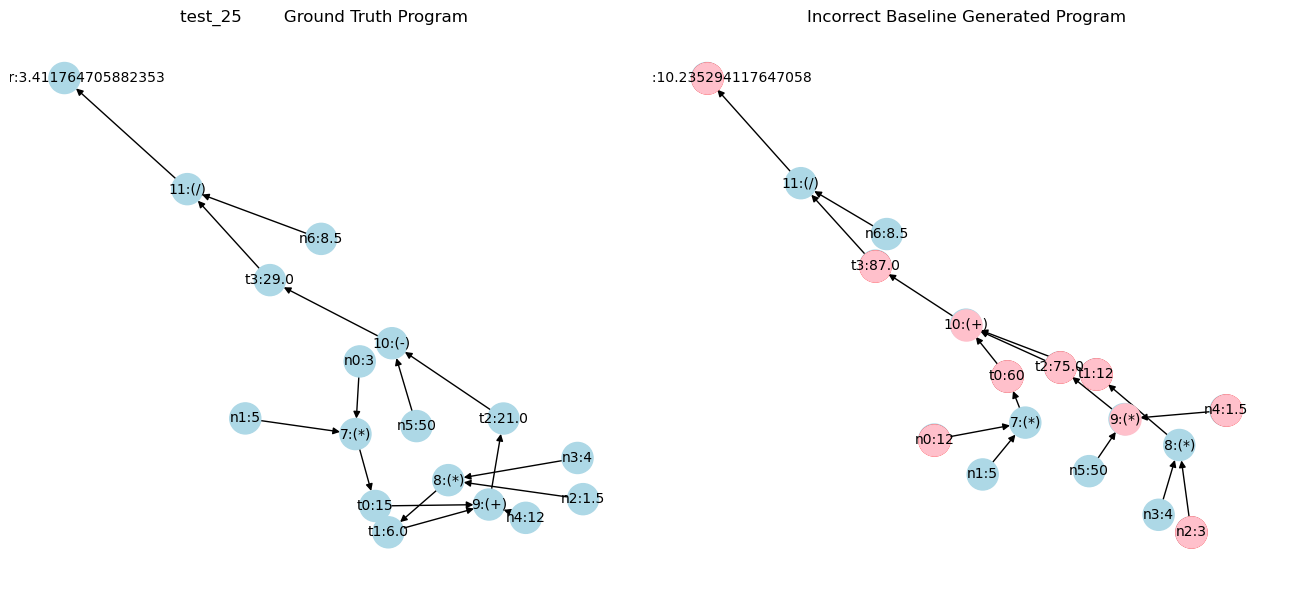

test_25
Unique nodes in Baseline Graph: {'n0', 'n4', '9:(+)', 't1', 'n2', 't2', 'answer', '10:(-)', 't0', 't3'}
Unique nodes in S3C Graph: {'n0', '9:(*)', 'n4', '10:(+)', 't1', 'n2', 't2', 'answer', 't0', 't3'}
Unique edges in Baseline Graph: {('10:(-)', 't3'), ('9:(+)', 't2'), ('n4', '9:(+)'), ('n5', '10:(-)'), ('t0', '9:(+)'), ('t2', '10:(-)'), ('t1', '9:(+)')}
Unique edges in S3C Graph: {('t1', '10:(+)'), ('9:(*)', 't2'), ('10:(+)', 't3'), ('t0', '10:(+)'), ('n4', '9:(*)'), ('t2', '10:(+)'), ('n5', '9:(*)')}
GT Answer 2.0 , S3C Generated Answer: 17.294117647058822
----------------------------------------------------------------


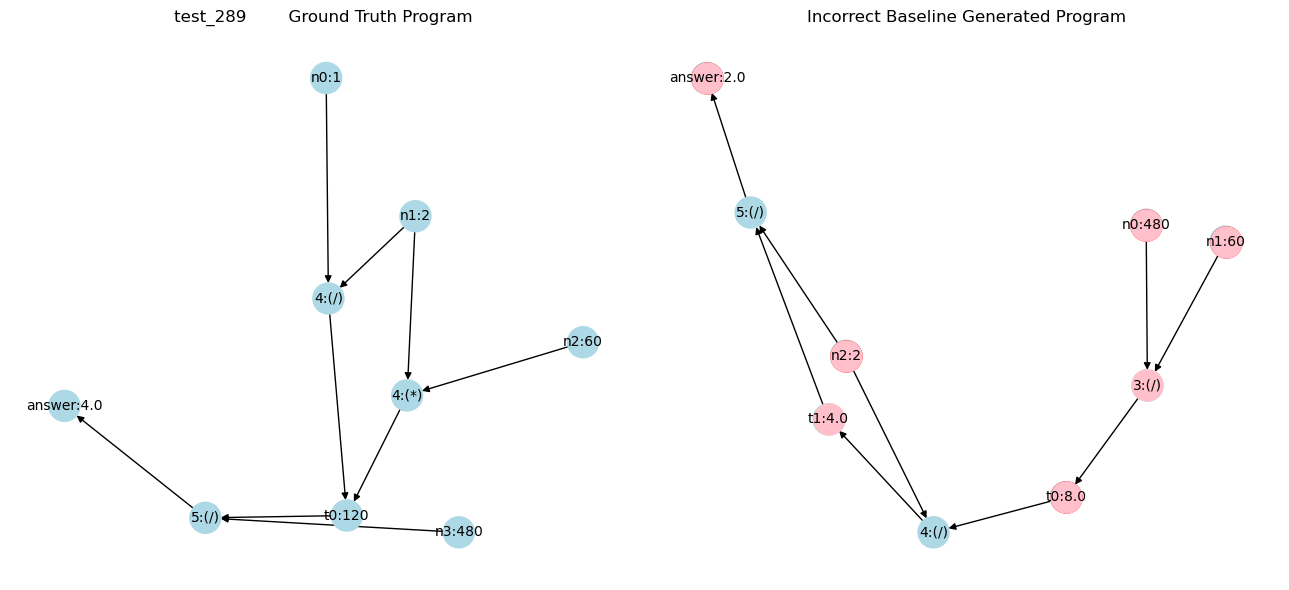

test_289
Unique nodes in Baseline Graph: {'n0', 'n3', 'n2', 'answer', 'n1', 't0', '4:(*)'}
Unique nodes in S3C Graph: {'n0', 't1', 'n2', 'answer', 'n1', '3:(/)', 't0'}
Unique edges in Baseline Graph: {('n1', '4:(*)'), ('n0', '4:(/)'), ('4:(*)', 't0'), ('n1', '4:(/)'), ('4:(/)', 't0'), ('n3', '5:(/)'), ('t0', '5:(/)'), ('n2', '4:(*)')}
Unique edges in S3C Graph: {('t1', '5:(/)'), ('3:(/)', 't0'), ('n0', '3:(/)'), ('n2', '4:(/)'), ('4:(/)', 't1'), ('n2', '5:(/)'), ('n1', '3:(/)'), ('t0', '4:(/)')}
GT Answer 16.0 , S3C Generated Answer: 2.0
----------------------------------------------------------------


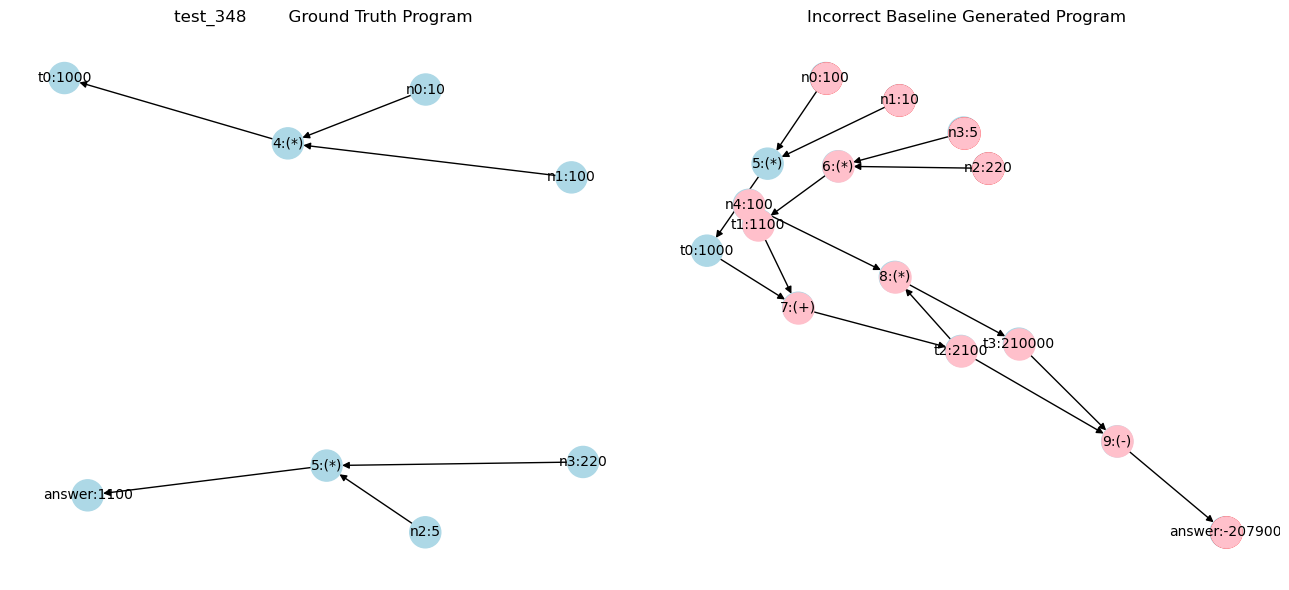

test_348
Unique nodes in Baseline Graph: {'n0', 'n3', 'n2', 'answer', 'n1', '4:(*)'}
Unique nodes in S3C Graph: {'n0', '7:(+)', 'n4', 't1', 'n3', 'n2', 't2', '8:(*)', 'answer', '9:(-)', 'n1', '6:(*)', 't3'}
Unique edges in Baseline Graph: {('n1', '4:(*)'), ('5:(*)', 'answer'), ('4:(*)', 't0'), ('n2', '5:(*)'), ('n0', '4:(*)'), ('n3', '5:(*)')}
Unique edges in S3C Graph: {('8:(*)', 't3'), ('t0', '7:(+)'), ('t2', '9:(-)'), ('n2', '6:(*)'), ('n4', '8:(*)'), ('n3', '6:(*)'), ('t1', '7:(+)'), ('n0', '5:(*)'), ('t2', '8:(*)'), ('6:(*)', 't1'), ('t3', '9:(-)'), ('7:(+)', 't2'), ('9:(-)', 'answer'), ('n1', '5:(*)'), ('5:(*)', 't0')}
GT Answer 10.0 , S3C Generated Answer: -207900
----------------------------------------------------------------


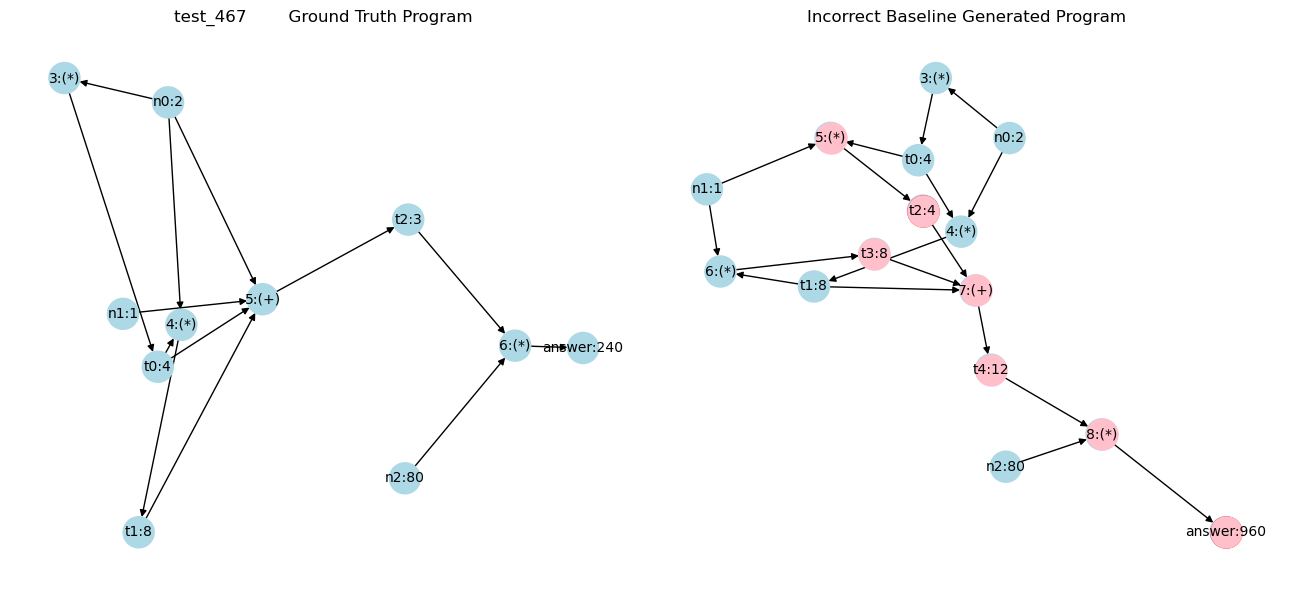

test_467
Unique nodes in Baseline Graph: {'t2', '5:(+)', 'answer'}
Unique nodes in S3C Graph: {'7:(+)', 'answer', 't2', '5:(*)', 't4', '8:(*)', 't3'}
Unique edges in Baseline Graph: {('n0', '5:(+)'), ('6:(*)', 'answer'), ('n1', '5:(+)'), ('n2', '6:(*)'), ('t0', '5:(+)'), ('t2', '6:(*)'), ('5:(+)', 't2'), ('t1', '5:(+)')}
Unique edges in S3C Graph: {('5:(*)', 't2'), ('t4', '8:(*)'), ('t2', '7:(+)'), ('t1', '6:(*)'), ('n2', '8:(*)'), ('8:(*)', 'answer'), ('7:(+)', 't4'), ('t1', '7:(+)'), ('n1', '6:(*)'), ('6:(*)', 't3'), ('n1', '5:(*)'), ('t0', '5:(*)'), ('t3', '7:(+)')}
GT Answer 1200.0 , S3C Generated Answer: 1600
----------------------------------------------------------------


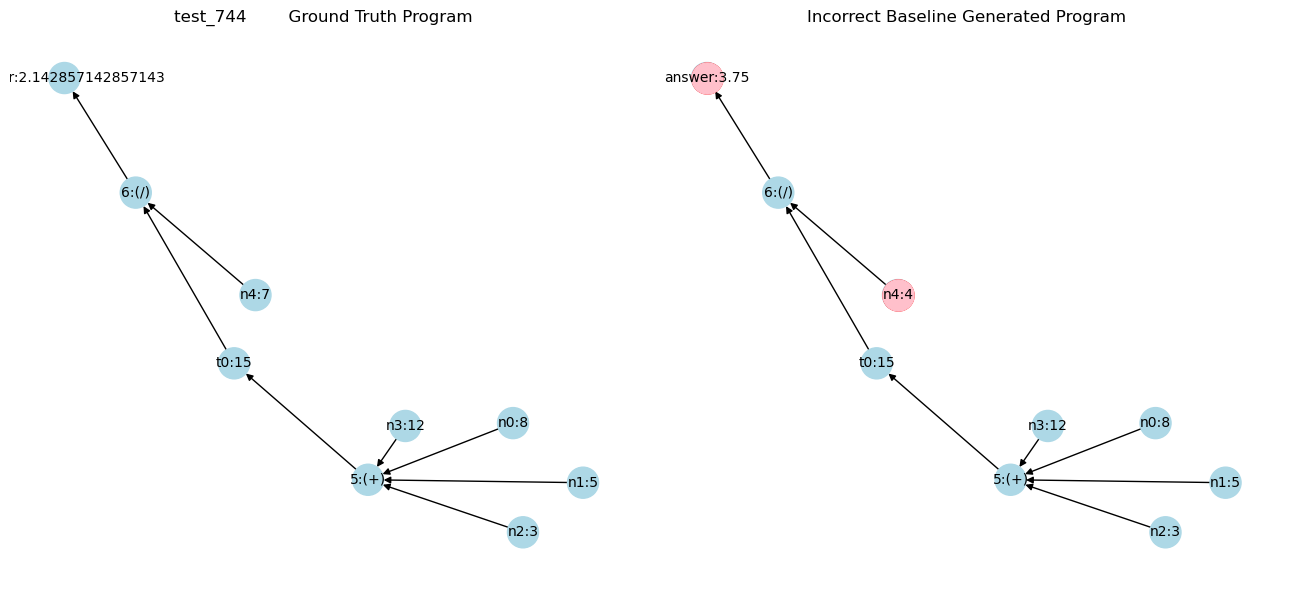

test_744
Unique nodes in Baseline Graph: {'n4', 'answer'}
Unique nodes in S3C Graph: {'n4', 'answer'}
Unique edges in Baseline Graph: set()
Unique edges in S3C Graph: set()
GT Answer 4.0 , S3C Generated Answer: 7.0
----------------------------------------------------------------


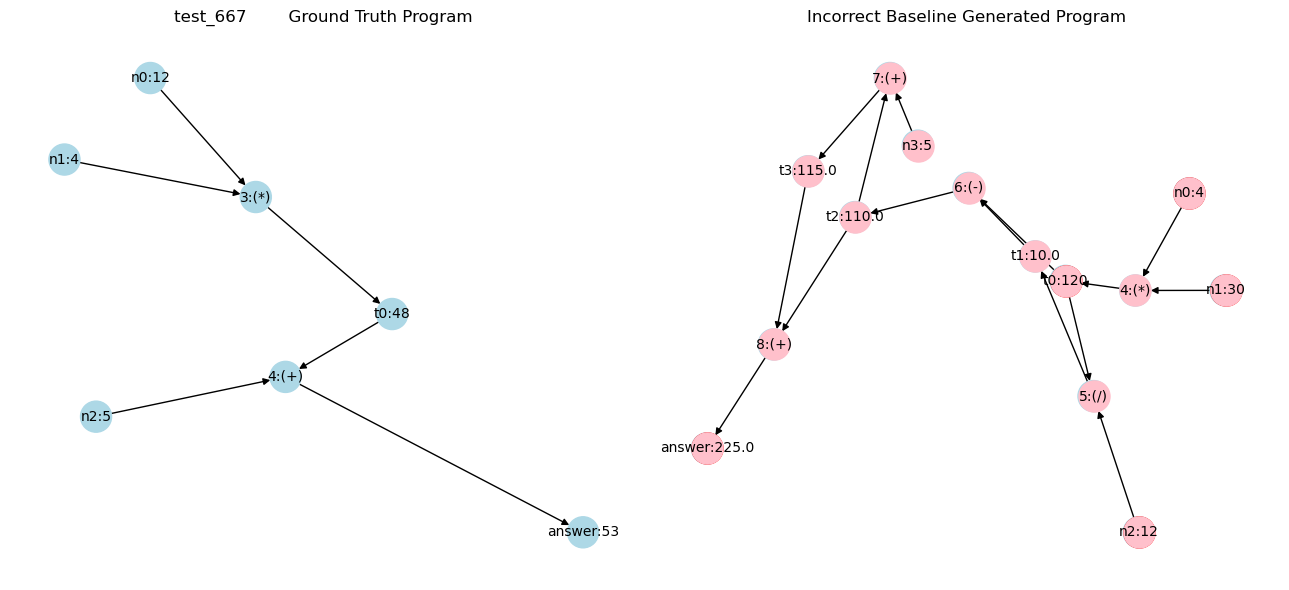

test_667
Unique nodes in Baseline Graph: {'n0', '4:(+)', 'n2', 'answer', '3:(*)', 'n1', 't0'}
Unique nodes in S3C Graph: {'n0', '7:(+)', '6:(-)', '5:(/)', 't1', 'n3', 'n2', 't2', 'answer', 'n1', 't0', '8:(+)', '4:(*)', 't3'}
Unique edges in Baseline Graph: {('t0', '4:(+)'), ('n0', '3:(*)'), ('3:(*)', 't0'), ('4:(+)', 'answer'), ('n1', '3:(*)'), ('n2', '4:(+)')}
Unique edges in S3C Graph: {('t1', '6:(-)'), ('5:(/)', 't1'), ('t2', '7:(+)'), ('n1', '4:(*)'), ('t2', '8:(+)'), ('6:(-)', 't2'), ('t3', '8:(+)'), ('n3', '7:(+)'), ('t0', '6:(-)'), ('4:(*)', 't0'), ('7:(+)', 't3'), ('8:(+)', 'answer'), ('n2', '5:(/)'), ('n0', '4:(*)'), ('t0', '5:(/)')}
GT Answer 53.0 , S3C Generated Answer: 225.0
----------------------------------------------------------------


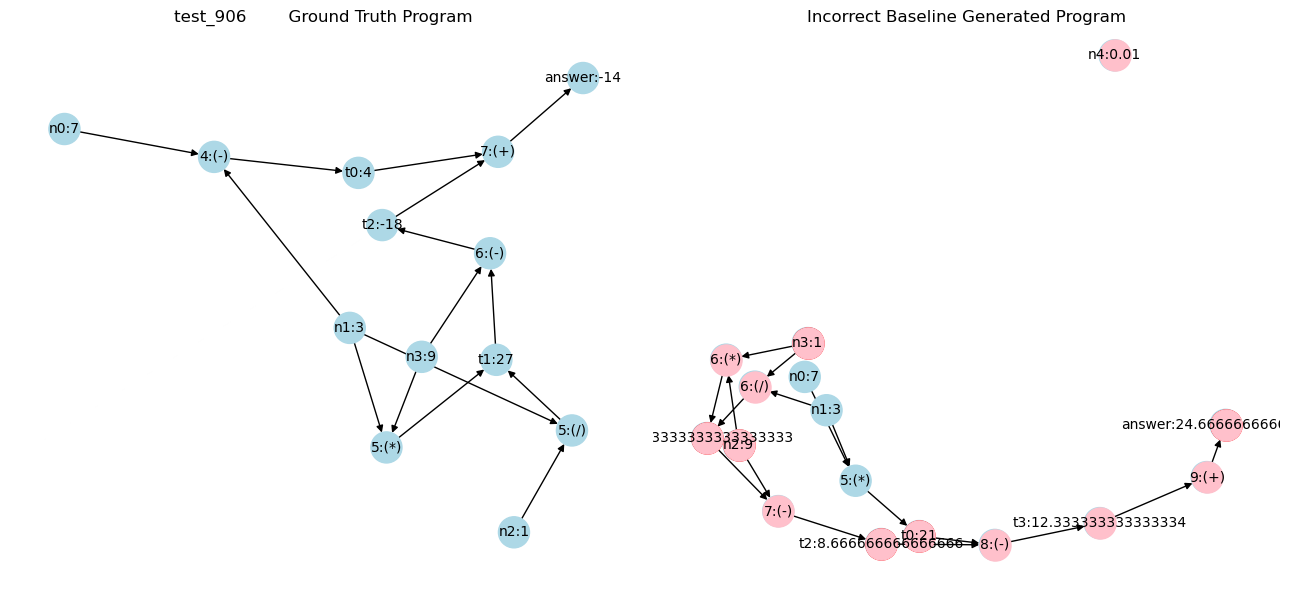

test_906
Unique nodes in Baseline Graph: {'4:(-)', '7:(+)', '6:(-)', '5:(/)', 't1', 'n3', 'n2', 't2', 'answer', 't0'}
Unique nodes in S3C Graph: {'8:(-)', 'n4', '7:(-)', '9:(+)', 't1', 'n3', 'n2', 't2', 'answer', '6:(/)', 't0', '6:(*)', 't3'}
Unique edges in Baseline Graph: {('t1', '6:(-)'), ('5:(/)', 't1'), ('t2', '7:(+)'), ('7:(+)', 'answer'), ('6:(-)', 't2'), ('n3', '6:(-)'), ('n0', '4:(-)'), ('n1', '5:(/)'), ('4:(-)', 't0'), ('n2', '5:(/)'), ('n1', '4:(-)'), ('5:(*)', 't1'), ('n3', '5:(*)'), ('t0', '7:(+)')}
Unique edges in S3C Graph: {('n1', '6:(/)'), ('7:(-)', 't2'), ('t0', '8:(-)'), ('n3', '6:(/)'), ('t2', '8:(-)'), ('n2', '6:(*)'), ('n3', '6:(*)'), ('n0', '5:(*)'), ('5:(*)', 't0'), ('t3', '9:(+)'), ('6:(*)', 't1'), ('8:(-)', 't3'), ('t1', '7:(-)'), ('6:(/)', 't1'), ('9:(+)', 'answer'), ('n2', '7:(-)')}
GT Answer 10.0 , S3C Generated Answer: 30.0
----------------------------------------------------------------


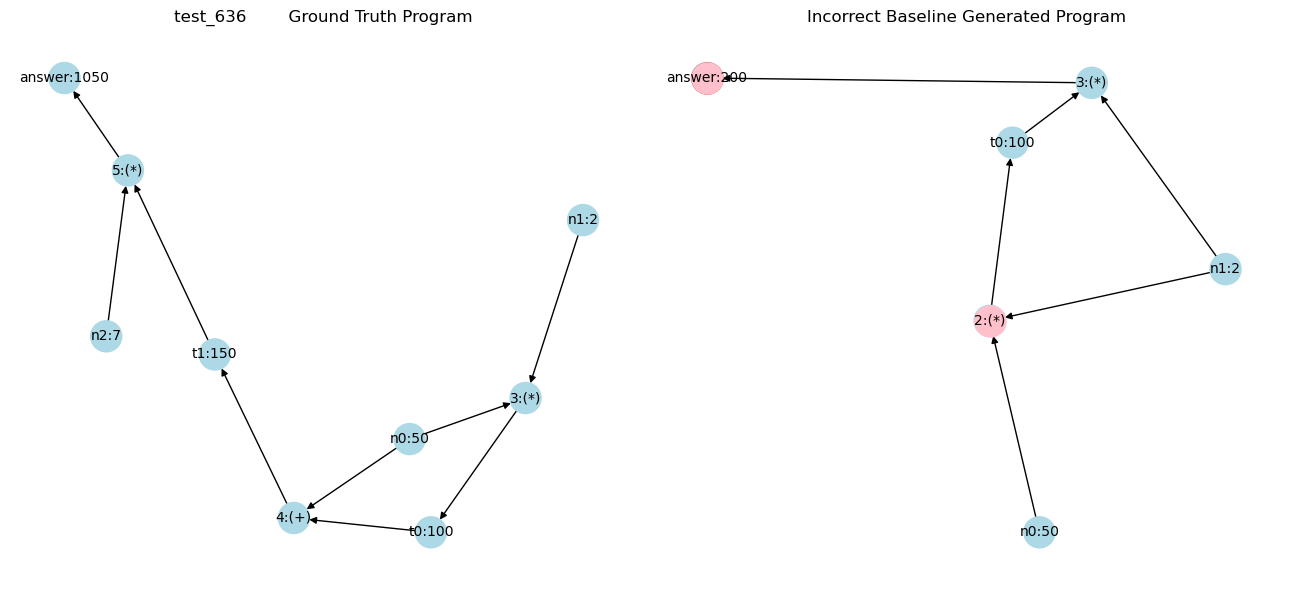

test_636
Unique nodes in Baseline Graph: {'4:(+)', 't1', 'answer', 'n2', '5:(*)'}
Unique nodes in S3C Graph: {'answer', '2:(*)'}
Unique edges in Baseline Graph: {('4:(+)', 't1'), ('t0', '4:(+)'), ('n0', '3:(*)'), ('5:(*)', 'answer'), ('3:(*)', 't0'), ('t1', '5:(*)'), ('n0', '4:(+)'), ('n2', '5:(*)')}
Unique edges in S3C Graph: {('2:(*)', 't0'), ('n0', '2:(*)'), ('n1', '2:(*)'), ('3:(*)', 'answer'), ('t0', '3:(*)')}
GT Answer 1050.0 , S3C Generated Answer: 200
----------------------------------------------------------------


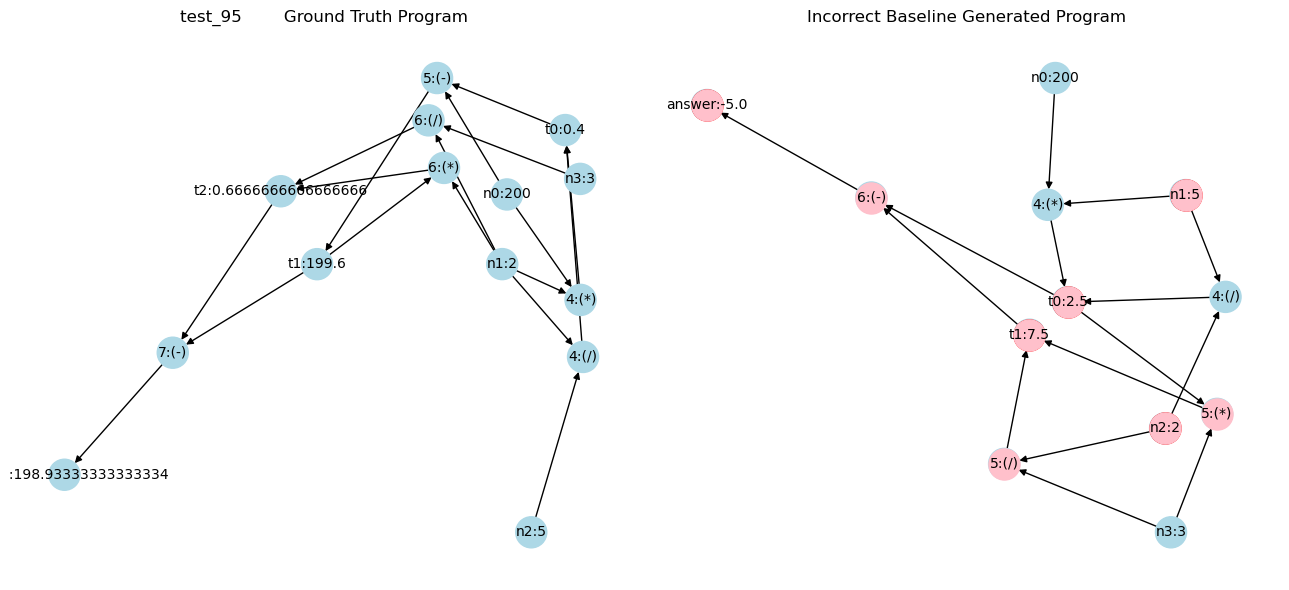

test_95
Unique nodes in Baseline Graph: {'7:(-)', 't1', 'n2', 't2', 'answer', '6:(/)', 'n1', 't0', '5:(-)', '6:(*)'}
Unique nodes in S3C Graph: {'6:(-)', '5:(/)', 't1', 'n2', 'answer', '5:(*)', 'n1', 't0'}
Unique edges in Baseline Graph: {('n1', '6:(/)'), ('6:(/)', 't2'), ('t1', '6:(*)'), ('n3', '6:(/)'), ('t0', '5:(-)'), ('t2', '7:(-)'), ('5:(-)', 't1'), ('7:(-)', 'answer'), ('n1', '6:(*)'), ('t1', '7:(-)'), ('n0', '5:(-)'), ('6:(*)', 't2')}
Unique edges in S3C Graph: {('t1', '6:(-)'), ('5:(/)', 't1'), ('n3', '5:(*)'), ('t0', '6:(-)'), ('6:(-)', 'answer'), ('5:(*)', 't1'), ('n2', '5:(/)'), ('n3', '5:(/)'), ('t0', '5:(*)')}
GT Answer 40.0 , S3C Generated Answer: 166.66666666666669
----------------------------------------------------------------


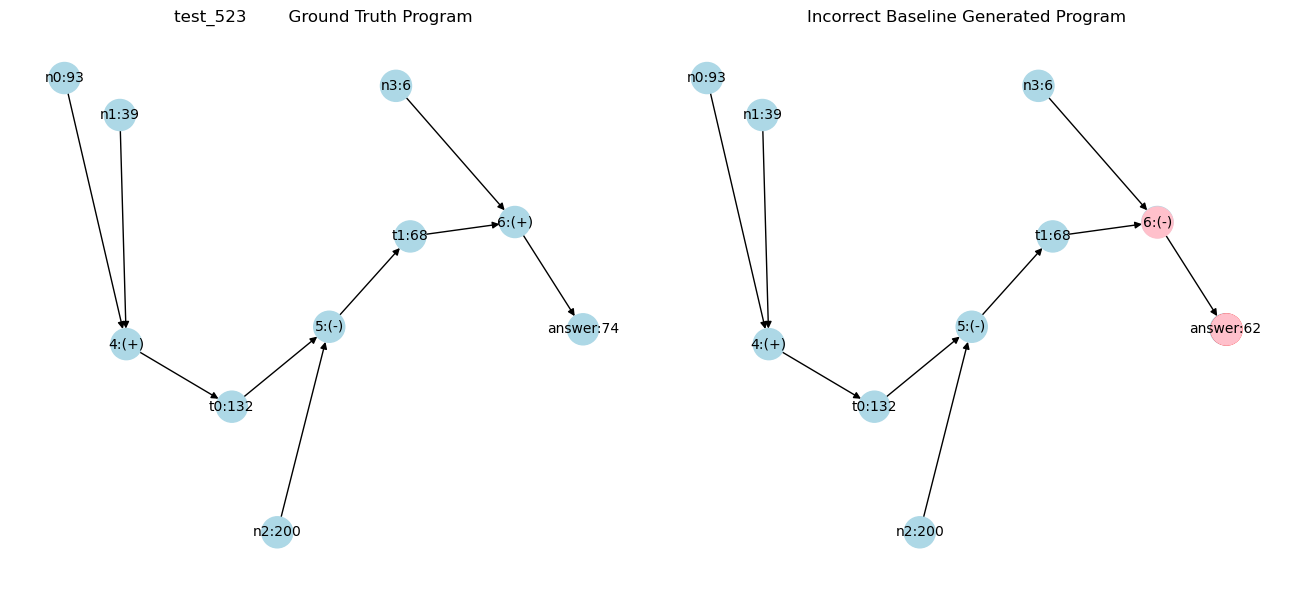

test_523
Unique nodes in Baseline Graph: {'6:(+)', 'answer'}
Unique nodes in S3C Graph: {'6:(-)', 'answer'}
Unique edges in Baseline Graph: {('n3', '6:(+)'), ('6:(+)', 'answer'), ('t1', '6:(+)')}
Unique edges in S3C Graph: {('t1', '6:(-)'), ('6:(-)', 'answer'), ('n3', '6:(-)')}
GT Answer 74.0 , S3C Generated Answer: 62
----------------------------------------------------------------


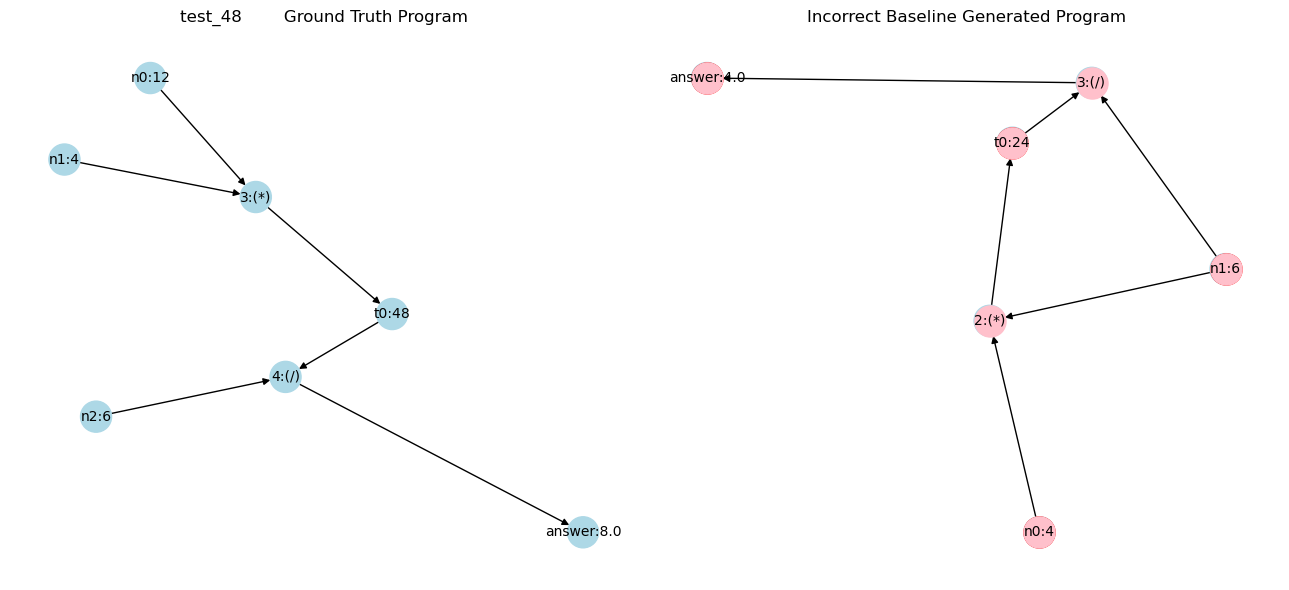

test_48
Unique nodes in Baseline Graph: {'n0', 'n2', '4:(/)', 'answer', '3:(*)', 'n1', 't0'}
Unique nodes in S3C Graph: {'n0', 'answer', 'n1', '3:(/)', 't0', '2:(*)'}
Unique edges in Baseline Graph: {('n0', '3:(*)'), ('4:(/)', 'answer'), ('3:(*)', 't0'), ('n2', '4:(/)'), ('n1', '3:(*)'), ('t0', '4:(/)')}
Unique edges in S3C Graph: {('3:(/)', 'answer'), ('2:(*)', 't0'), ('n0', '2:(*)'), ('n1', '2:(*)'), ('n1', '3:(/)'), ('t0', '3:(/)')}
GT Answer 8.0 , S3C Generated Answer: 4.0
----------------------------------------------------------------


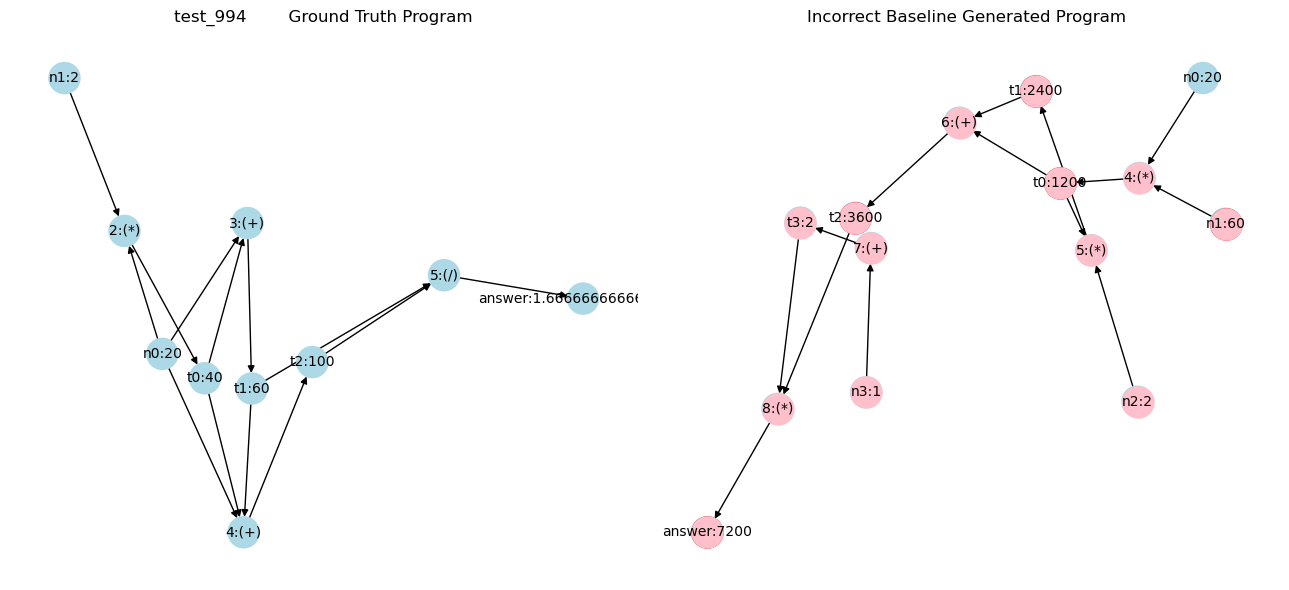

test_994
Unique nodes in Baseline Graph: {'4:(+)', '5:(/)', 't1', 'answer', 't2', 'n1', 't0', '3:(+)', '2:(*)'}
Unique nodes in S3C Graph: {'7:(+)', 't1', 'n3', 'n2', '6:(+)', '5:(*)', 't2', '8:(*)', 'answer', 'n1', 't0', '4:(*)', 't3'}
Unique edges in Baseline Graph: {('t2', '5:(/)'), ('t0', '4:(+)'), ('t1', '5:(/)'), ('2:(*)', 't0'), ('3:(+)', 't1'), ('n0', '2:(*)'), ('t0', '3:(+)'), ('4:(+)', 't2'), ('t1', '4:(+)'), ('n0', '4:(+)'), ('n1', '2:(*)'), ('5:(/)', 'answer'), ('n0', '3:(+)')}
Unique edges in S3C Graph: {('6:(+)', 't2'), ('n1', '4:(*)'), ('8:(*)', 'answer'), ('t3', '8:(*)'), ('n3', '7:(+)'), ('4:(*)', 't0'), ('t2', '8:(*)'), ('t0', '6:(+)'), ('5:(*)', 't1'), ('7:(+)', 't3'), ('n2', '5:(*)'), ('n0', '4:(*)'), ('t0', '5:(*)'), ('t1', '6:(+)')}
GT Answer 2.0 , S3C Generated Answer: 12000
----------------------------------------------------------------


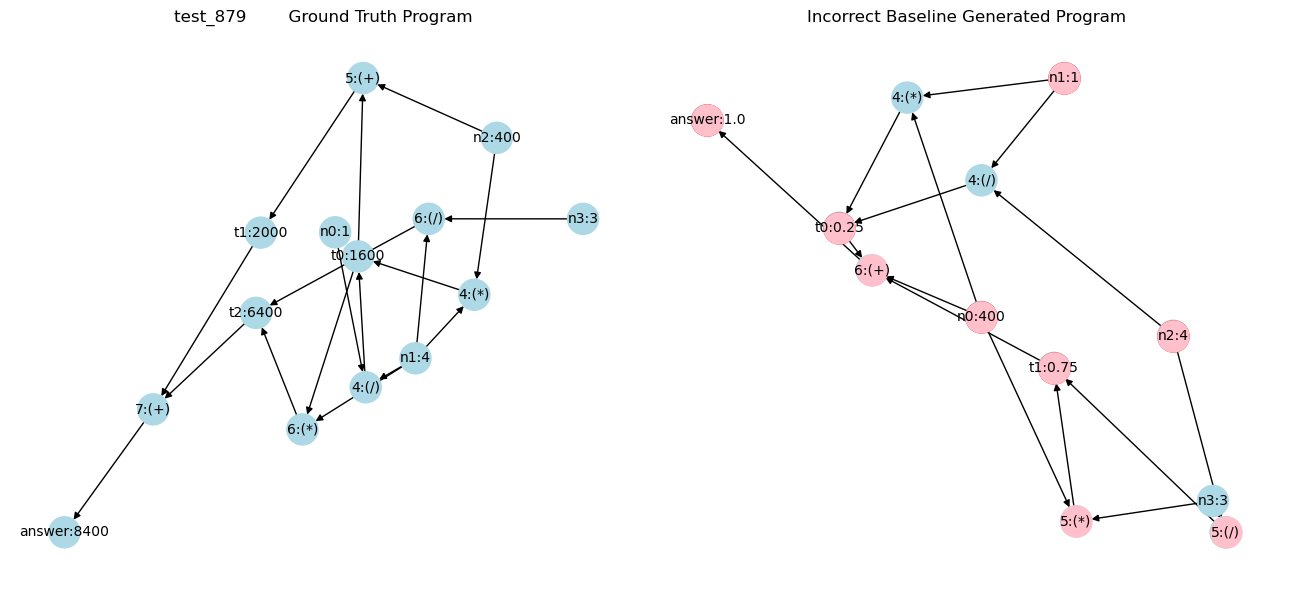

test_879
Unique nodes in Baseline Graph: {'n0', '7:(+)', 't1', 'n2', 't2', 'answer', '6:(/)', '5:(+)', 'n1', 't0', '6:(*)'}
Unique nodes in S3C Graph: {'n0', '5:(/)', 't1', '6:(+)', 'n2', 'answer', '5:(*)', 'n1', 't0'}
Unique edges in Baseline Graph: {('n1', '6:(/)'), ('6:(/)', 't2'), ('t2', '7:(+)'), ('7:(+)', 'answer'), ('n3', '6:(/)'), ('n2', '5:(+)'), ('n0', '4:(/)'), ('t1', '7:(+)'), ('5:(+)', 't1'), ('n1', '6:(*)'), ('6:(*)', 't2'), ('t0', '5:(+)'), ('t0', '6:(*)'), ('n2', '4:(*)')}
Unique edges in S3C Graph: {('n0', '6:(+)'), ('5:(/)', 't1'), ('6:(+)', 'answer'), ('n3', '5:(/)'), ('n2', '4:(/)'), ('n0', '5:(*)'), ('t0', '6:(+)'), ('5:(*)', 't1'), ('n2', '5:(/)'), ('n0', '4:(*)'), ('n3', '5:(*)'), ('t1', '6:(+)')}
GT Answer 575.0 , S3C Generated Answer: 800.0
----------------------------------------------------------------


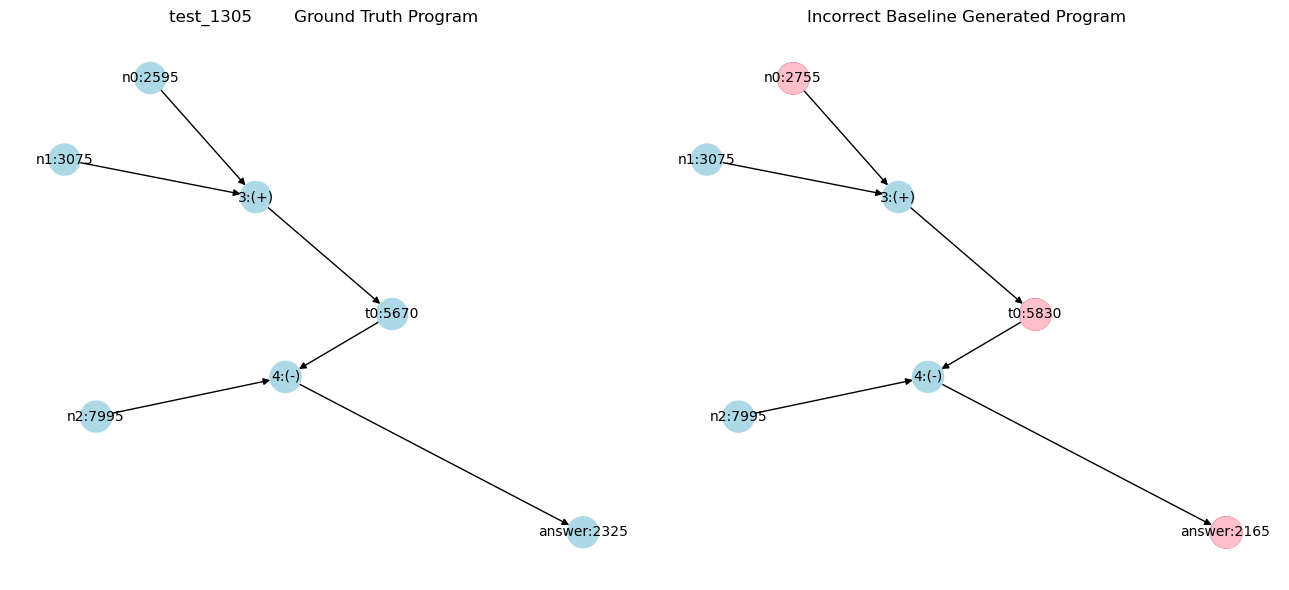

test_1305
Unique nodes in Baseline Graph: {'n0', 't0', 'answer'}
Unique nodes in S3C Graph: {'n0', 't0', 'answer'}
Unique edges in Baseline Graph: set()
Unique edges in S3C Graph: set()
GT Answer 2325.0 , S3C Generated Answer: 2165
----------------------------------------------------------------


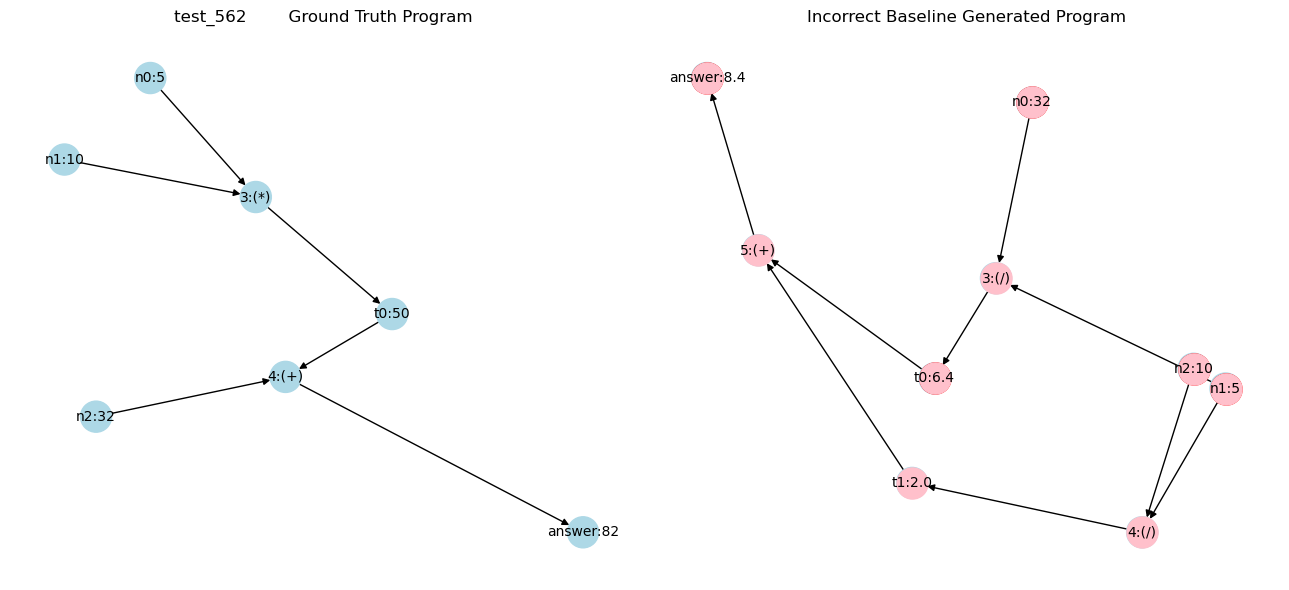

test_562
Unique nodes in Baseline Graph: {'n0', '4:(+)', 'n2', 'answer', '3:(*)', 'n1', 't0'}
Unique nodes in S3C Graph: {'n0', 't1', 'n2', '4:(/)', 'answer', '5:(+)', 'n1', '3:(/)', 't0'}
Unique edges in Baseline Graph: {('t0', '4:(+)'), ('n0', '3:(*)'), ('3:(*)', 't0'), ('4:(+)', 'answer'), ('n1', '3:(*)'), ('n2', '4:(+)')}
Unique edges in S3C Graph: {('5:(+)', 'answer'), ('3:(/)', 't0'), ('n0', '3:(/)'), ('n2', '4:(/)'), ('t0', '5:(+)'), ('4:(/)', 't1'), ('n1', '4:(/)'), ('n1', '3:(/)'), ('t1', '5:(+)')}
GT Answer 82.0 , S3C Generated Answer: 8.4
----------------------------------------------------------------


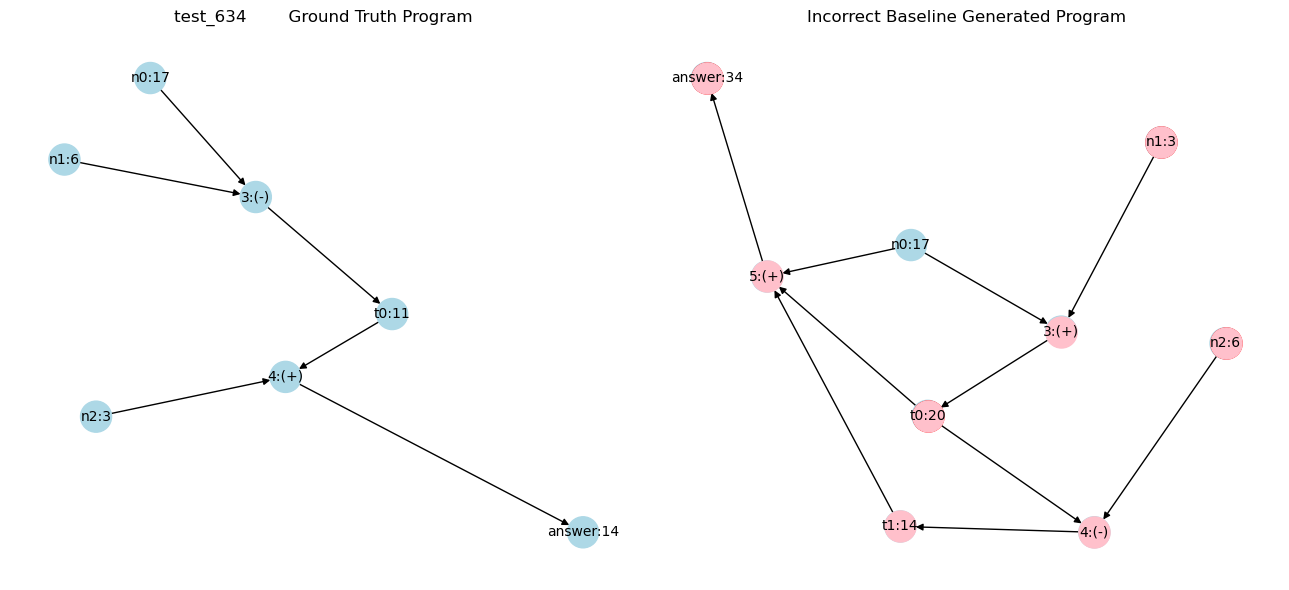

test_634
Unique nodes in Baseline Graph: {'4:(+)', 'n2', 'answer', '3:(-)', 'n1', 't0'}
Unique nodes in S3C Graph: {'4:(-)', 't1', 'n2', 'answer', '5:(+)', 'n1', 't0', '3:(+)'}
Unique edges in Baseline Graph: {('t0', '4:(+)'), ('n0', '3:(-)'), ('3:(-)', 't0'), ('4:(+)', 'answer'), ('n1', '3:(-)'), ('n2', '4:(+)')}
Unique edges in S3C Graph: {('n0', '5:(+)'), ('t0', '4:(-)'), ('n2', '4:(-)'), ('n1', '3:(+)'), ('5:(+)', 'answer'), ('3:(+)', 't0'), ('t0', '5:(+)'), ('4:(-)', 't1'), ('n0', '3:(+)'), ('t1', '5:(+)')}
GT Answer 14.0 , S3C Generated Answer: 51
----------------------------------------------------------------


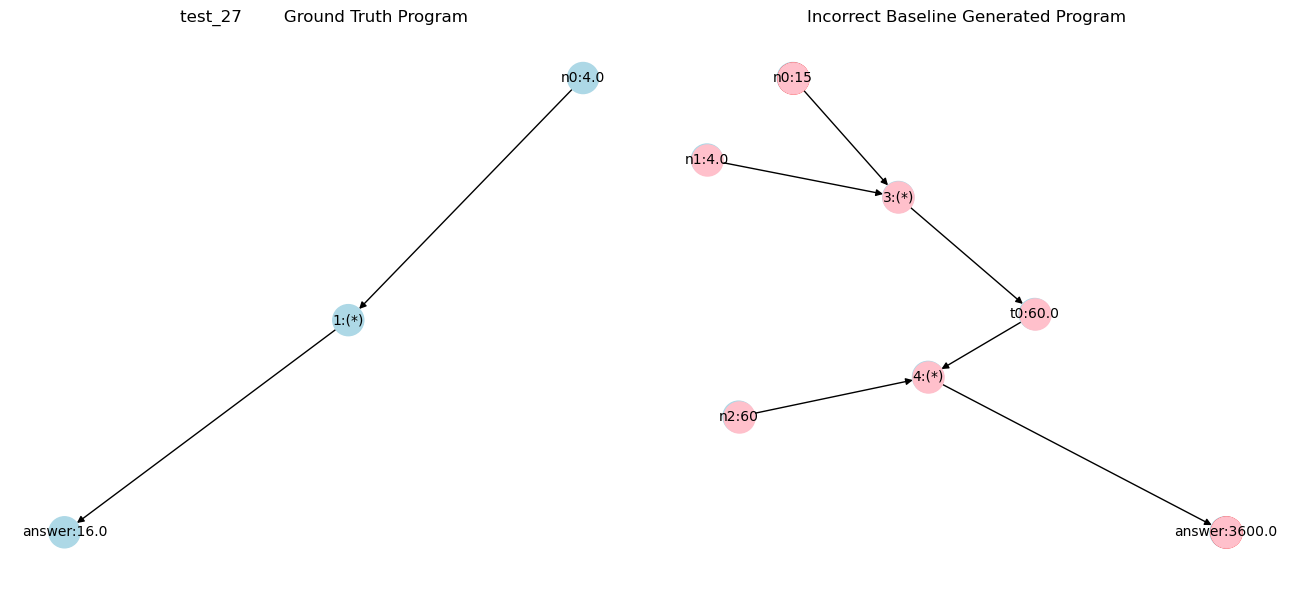

test_27
Unique nodes in Baseline Graph: {'n0', '1:(*)', 'answer'}
Unique nodes in S3C Graph: {'n0', 'n2', 'answer', '3:(*)', 'n1', 't0', '4:(*)'}
Unique edges in Baseline Graph: {('1:(*)', 'answer'), ('n0', '1:(*)')}
Unique edges in S3C Graph: {('n0', '3:(*)'), ('3:(*)', 't0'), ('t0', '4:(*)'), ('n1', '3:(*)'), ('4:(*)', 'answer'), ('n2', '4:(*)')}
GT Answer 16.0 , S3C Generated Answer: 3600.0
----------------------------------------------------------------


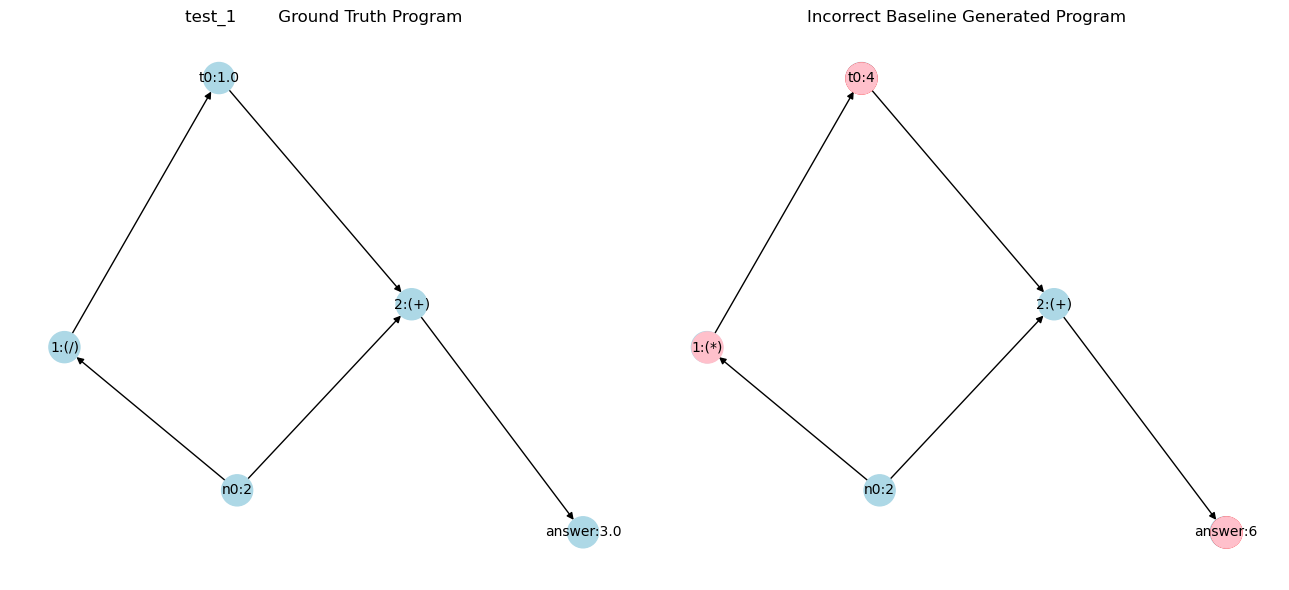

test_1
Unique nodes in Baseline Graph: {'t0', '1:(/)', 'answer'}
Unique nodes in S3C Graph: {'t0', '1:(*)', 'answer'}
Unique edges in Baseline Graph: {('n0', '1:(/)'), ('1:(/)', 't0')}
Unique edges in S3C Graph: {('n0', '1:(*)'), ('1:(*)', 't0')}
GT Answer 3.0 , S3C Generated Answer: 6
----------------------------------------------------------------


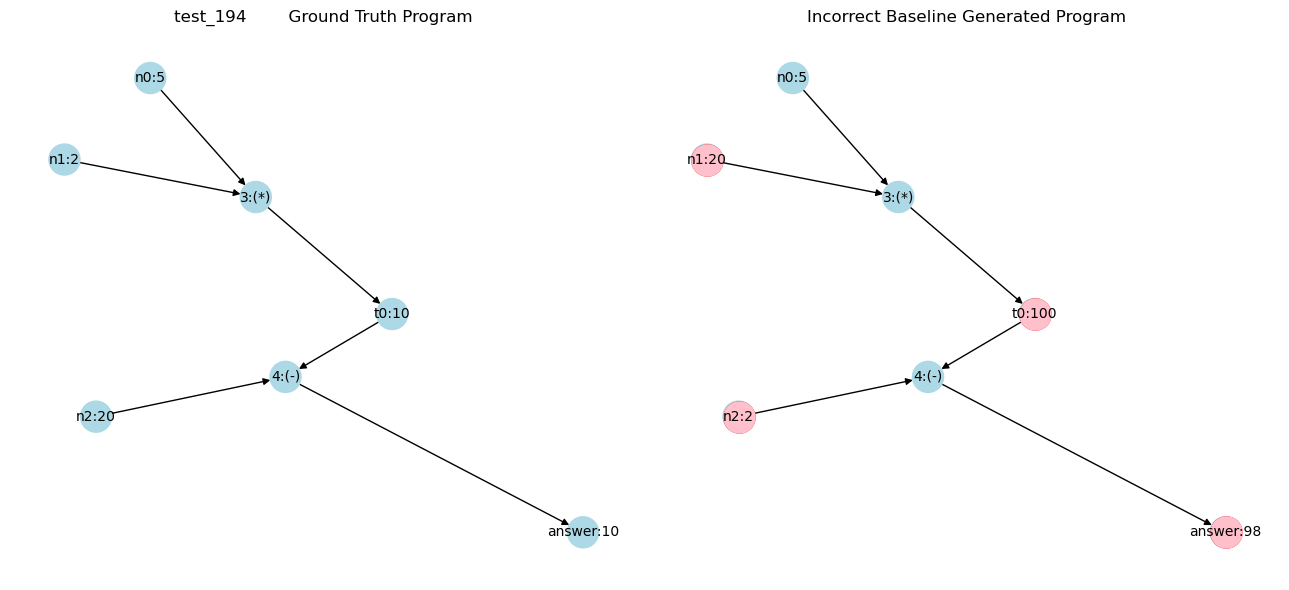

test_194
Unique nodes in Baseline Graph: {'t0', 'answer', 'n1', 'n2'}
Unique nodes in S3C Graph: {'t0', 'answer', 'n1', 'n2'}
Unique edges in Baseline Graph: set()
Unique edges in S3C Graph: set()
GT Answer 10.0 , S3C Generated Answer: 98
----------------------------------------------------------------


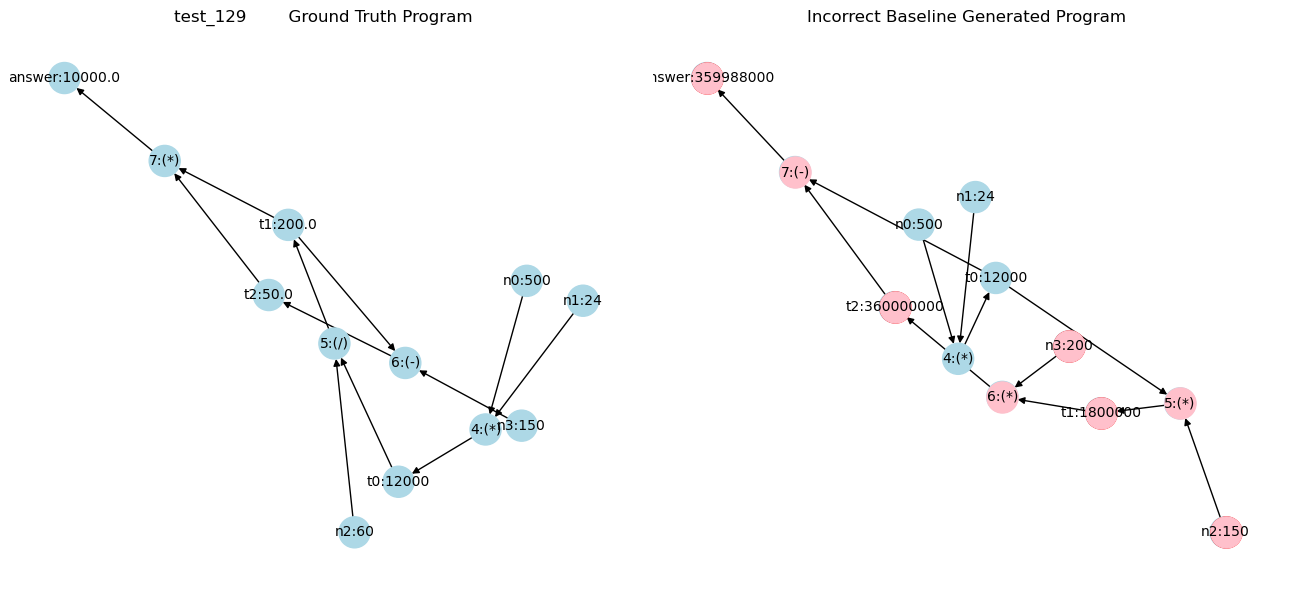

test_129
Unique nodes in Baseline Graph: {'6:(-)', '5:(/)', 't1', 'n3', 'n2', 't2', 'answer', '7:(*)'}
Unique nodes in S3C Graph: {'7:(-)', 't1', 'n3', 'n2', 't2', '5:(*)', 'answer', '6:(*)'}
Unique edges in Baseline Graph: {('t1', '6:(-)'), ('5:(/)', 't1'), ('t2', '7:(*)'), ('6:(-)', 't2'), ('n3', '6:(-)'), ('t1', '7:(*)'), ('7:(*)', 'answer'), ('n2', '5:(/)'), ('t0', '5:(/)')}
Unique edges in S3C Graph: {('t1', '6:(*)'), ('t0', '7:(-)'), ('t2', '7:(-)'), ('7:(-)', 'answer'), ('n3', '6:(*)'), ('5:(*)', 't1'), ('n2', '5:(*)'), ('t0', '5:(*)'), ('6:(*)', 't2')}
GT Answer 10000.0 , S3C Generated Answer: 359988000
----------------------------------------------------------------


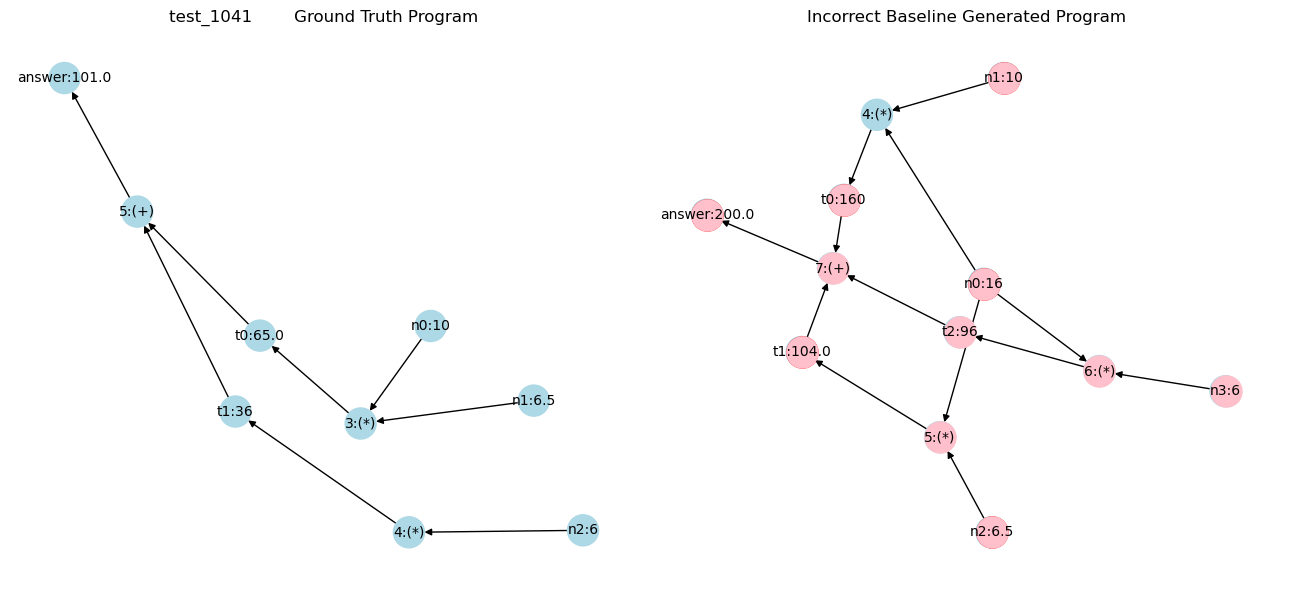

test_1041
Unique nodes in Baseline Graph: {'n0', 't1', 'n2', 'answer', '5:(+)', '3:(*)', 'n1', 't0'}
Unique nodes in S3C Graph: {'n0', '7:(+)', 't1', 'n3', 'n2', 't2', '5:(*)', 'answer', 'n1', 't0', '6:(*)'}
Unique edges in Baseline Graph: {('5:(+)', 'answer'), ('n0', '3:(*)'), ('3:(*)', 't0'), ('4:(*)', 't1'), ('n1', '3:(*)'), ('t0', '5:(+)'), ('t1', '5:(+)'), ('n2', '4:(*)')}
Unique edges in S3C Graph: {('t2', '7:(+)'), ('n1', '4:(*)'), ('7:(+)', 'answer'), ('n0', '6:(*)'), ('t1', '7:(+)'), ('n3', '6:(*)'), ('n0', '5:(*)'), ('4:(*)', 't0'), ('5:(*)', 't1'), ('n2', '5:(*)'), ('n0', '4:(*)'), ('t0', '7:(+)'), ('6:(*)', 't2')}
GT Answer 101.0 , S3C Generated Answer: 360.0
----------------------------------------------------------------


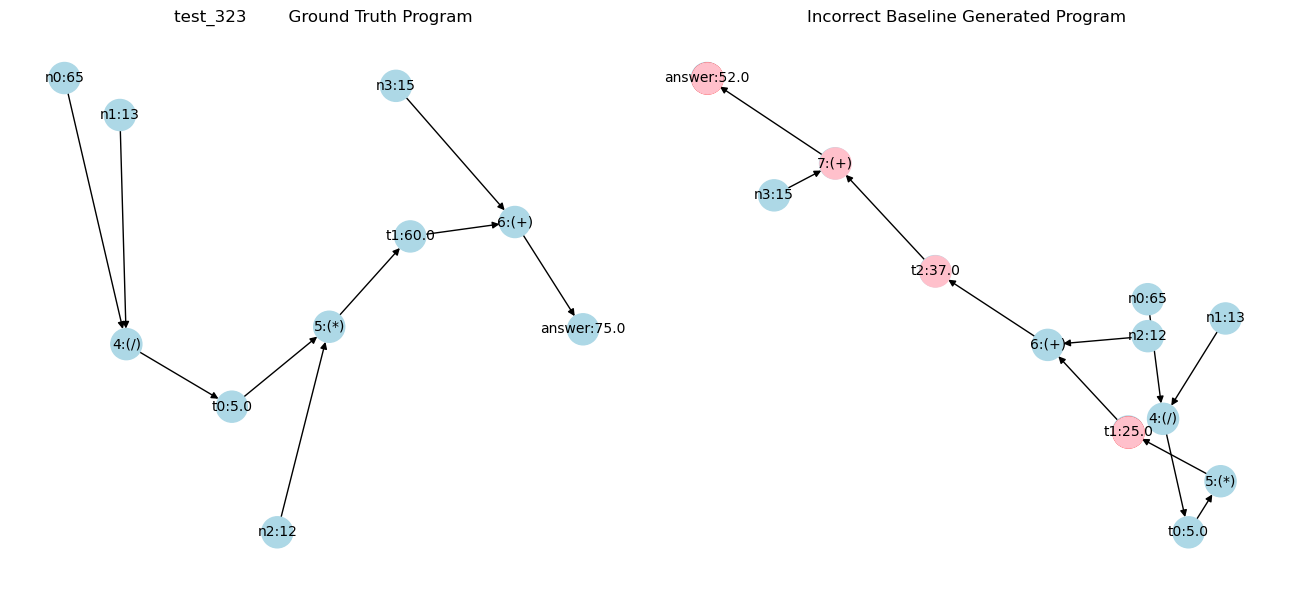

test_323
Unique nodes in Baseline Graph: {'t1', 'answer'}
Unique nodes in S3C Graph: {'t2', '7:(+)', 't1', 'answer'}
Unique edges in Baseline Graph: {('n3', '6:(+)'), ('6:(+)', 'answer'), ('n2', '5:(*)')}
Unique edges in S3C Graph: {('6:(+)', 't2'), ('7:(+)', 'answer'), ('t2', '7:(+)'), ('n2', '6:(+)'), ('n3', '7:(+)')}
GT Answer 75.0 , S3C Generated Answer: 52.0
----------------------------------------------------------------


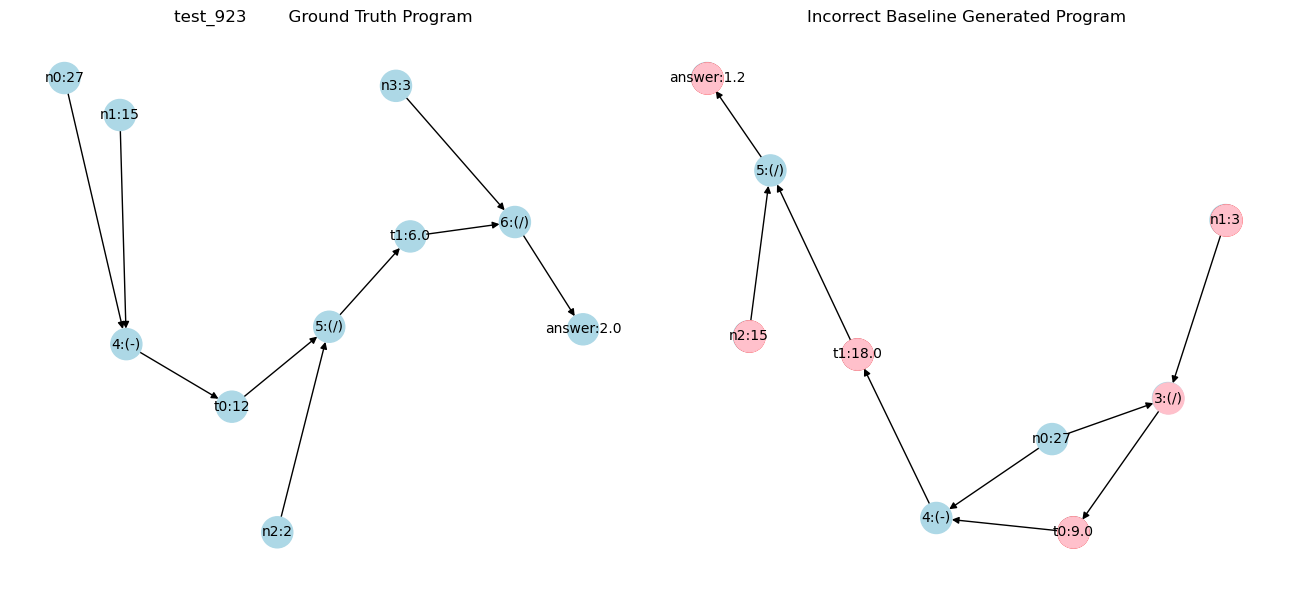

test_923
Unique nodes in Baseline Graph: {'t1', 'n3', 'n2', 'answer', '6:(/)', 'n1', 't0'}
Unique nodes in S3C Graph: {'t1', 'n2', 'answer', 'n1', '3:(/)', 't0'}
Unique edges in Baseline Graph: {('5:(/)', 't1'), ('n3', '6:(/)'), ('6:(/)', 'answer'), ('t1', '6:(/)'), ('4:(-)', 't0'), ('n1', '4:(-)'), ('t0', '5:(/)')}
Unique edges in S3C Graph: {('t0', '4:(-)'), ('t1', '5:(/)'), ('3:(/)', 't0'), ('n0', '3:(/)'), ('4:(-)', 't1'), ('5:(/)', 'answer'), ('n1', '3:(/)')}
GT Answer 2.0 , S3C Generated Answer: 1.2
----------------------------------------------------------------


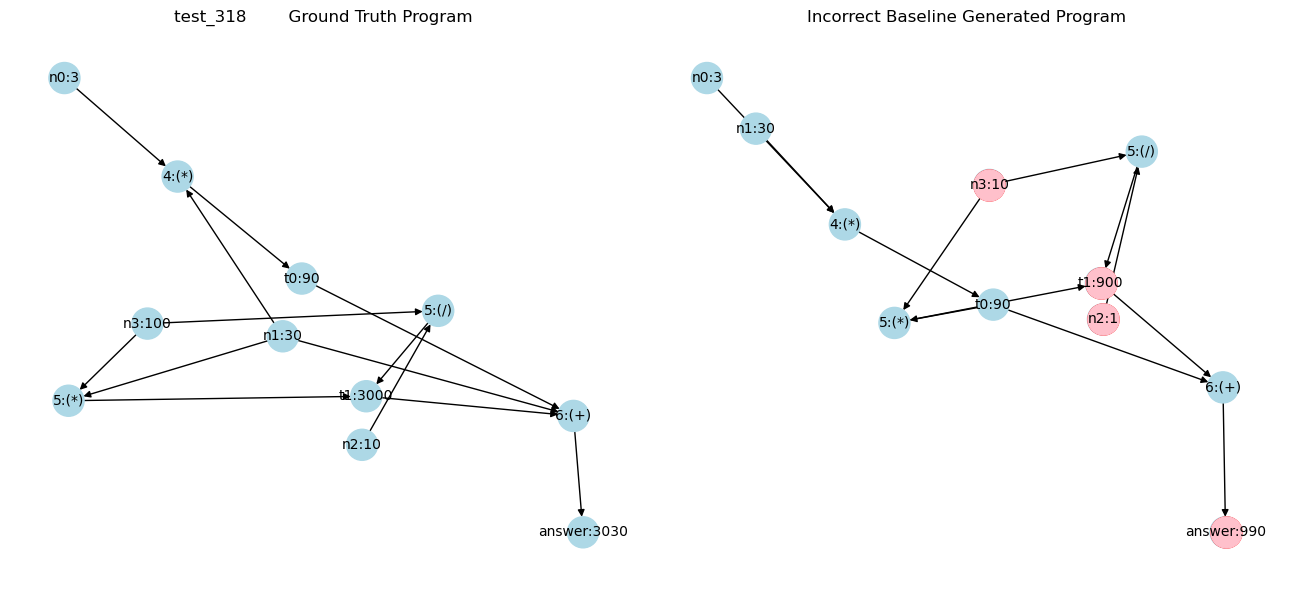

test_318
Unique nodes in Baseline Graph: {'answer', 't1', 'n3', 'n2'}
Unique nodes in S3C Graph: {'answer', 't1', 'n3', 'n2'}
Unique edges in Baseline Graph: {('n1', '6:(+)'), ('n1', '5:(*)')}
Unique edges in S3C Graph: {('t0', '5:(*)')}
GT Answer 123.0 , S3C Generated Answer: 99.0
----------------------------------------------------------------


TypeError: unsupported operand type(s) for *: 'int' and 'NoneType'

In [44]:
#print_graph_comparisons(tf_intersection, baseline_dict, s3c_dict, incorrect_baseline_clusters, correct_s3c_clusters)